In [30]:
import os
import sys
import uproot
import peakutils

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/') ## Choose right path
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [27]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [4]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [5]:
fav_col = '#418094'

## Load file example:

In [31]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-09_10_2024-file_10.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

#### Plot one event:

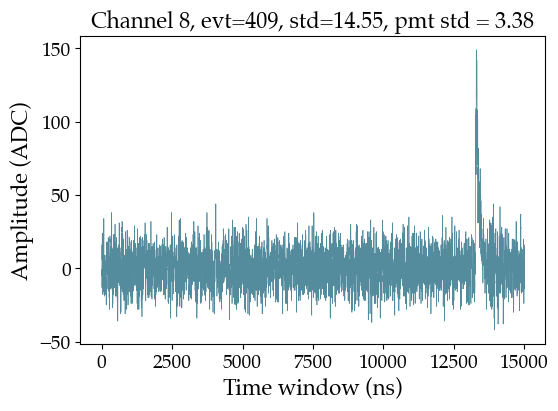

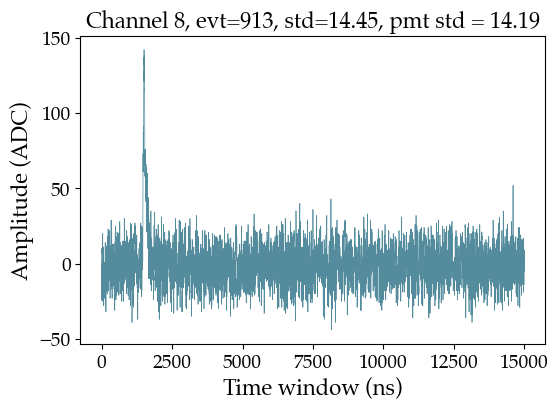

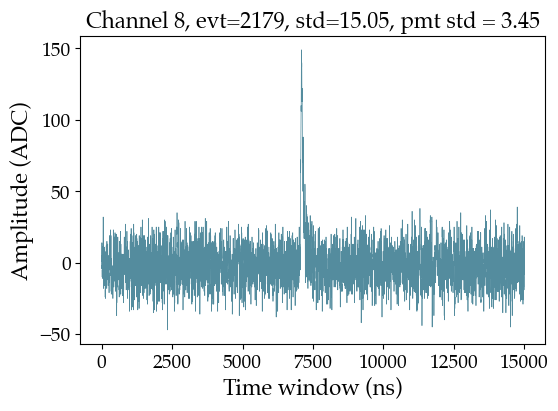

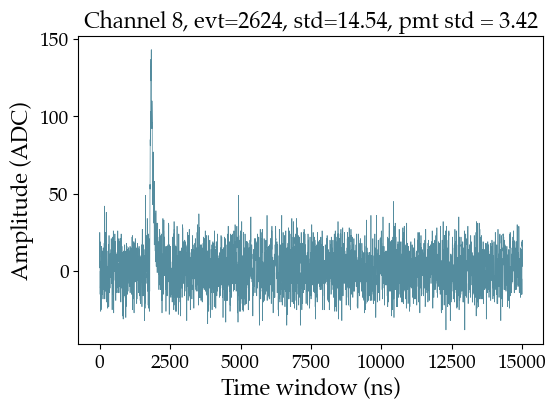

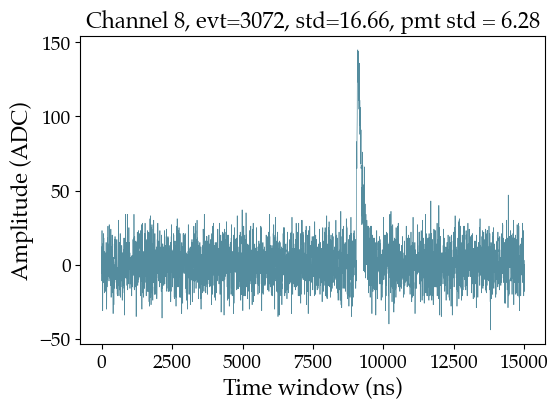

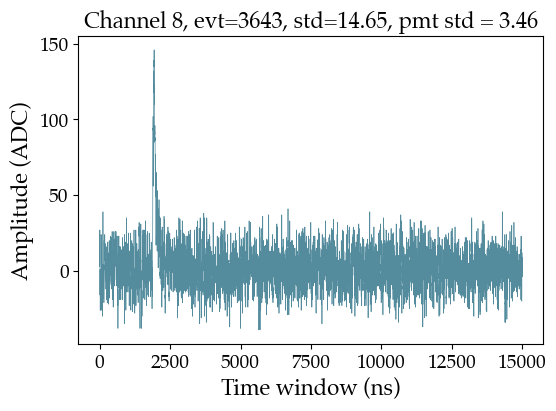

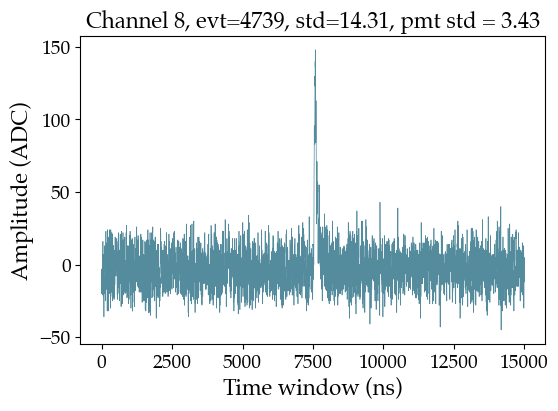

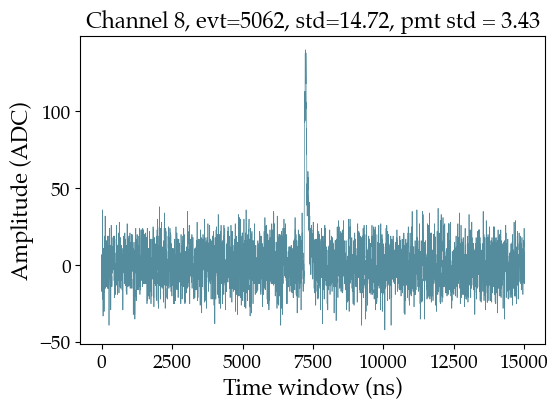

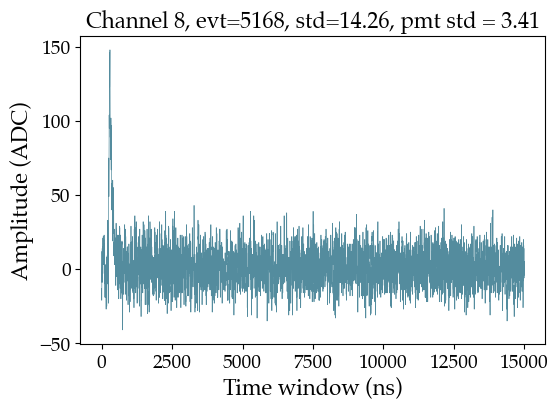

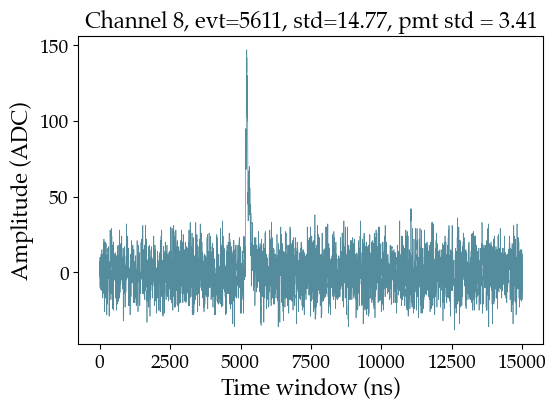

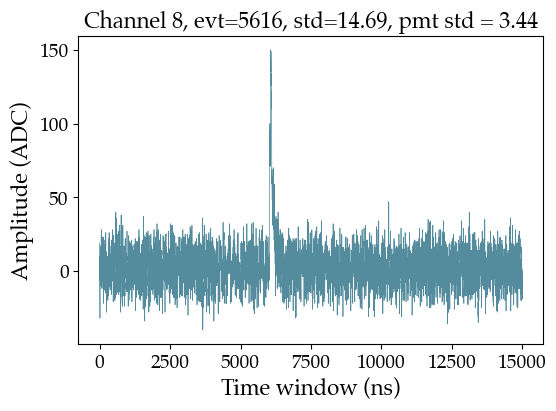

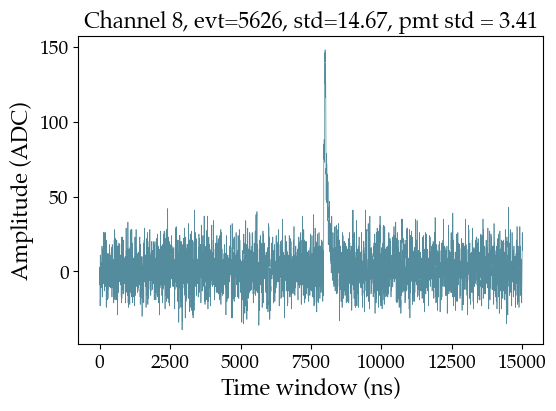

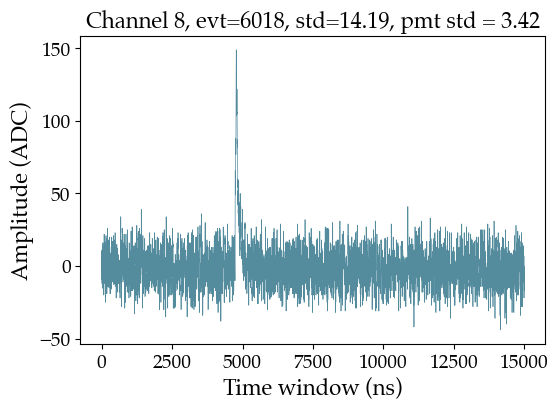

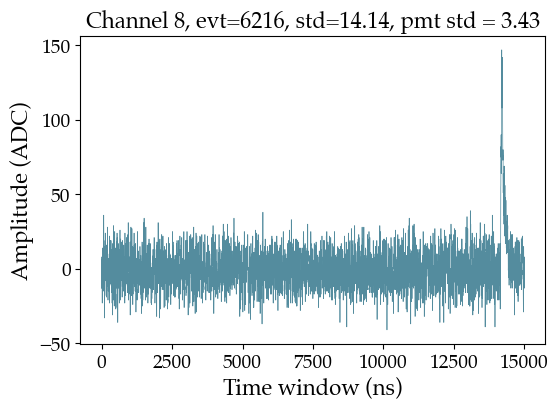

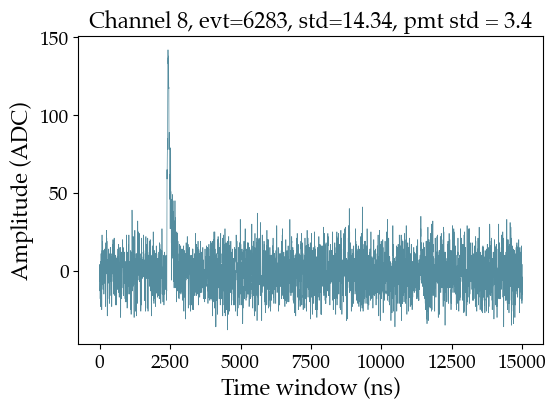

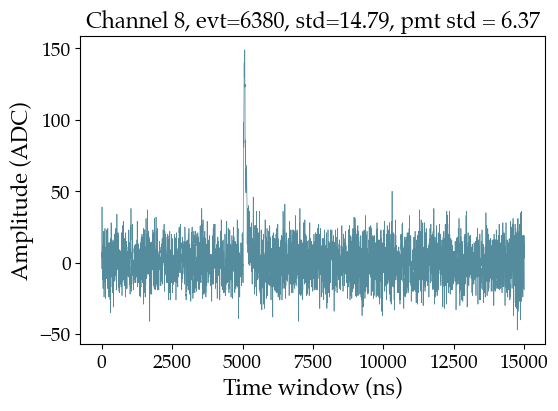

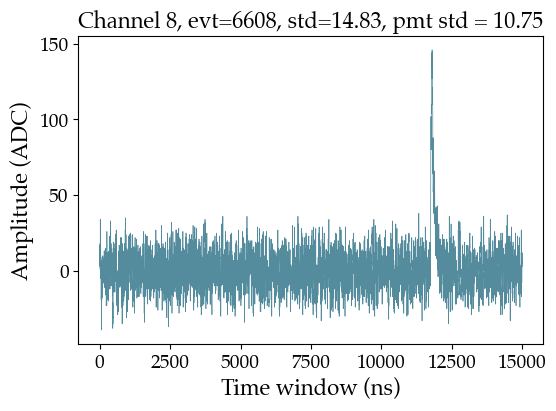

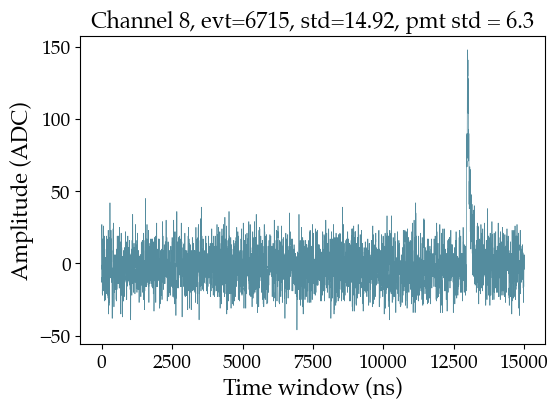

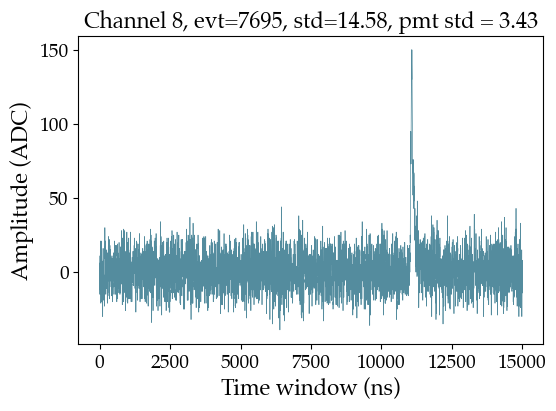

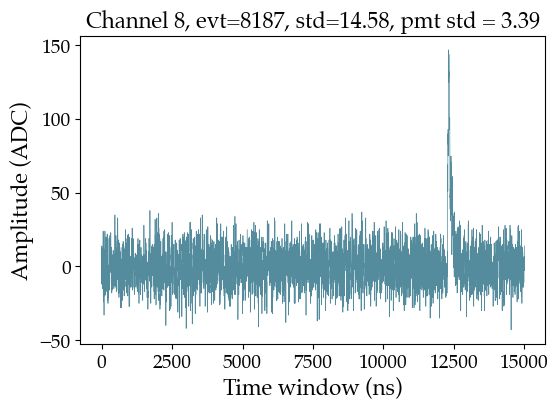

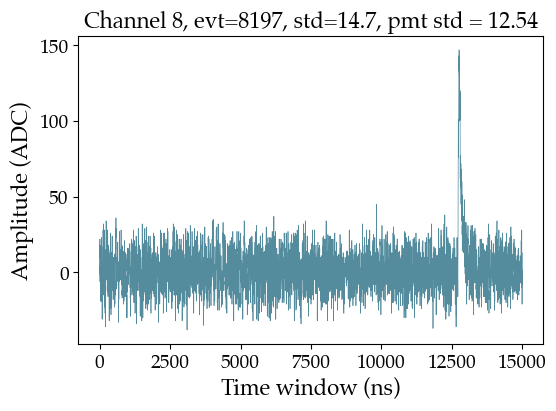

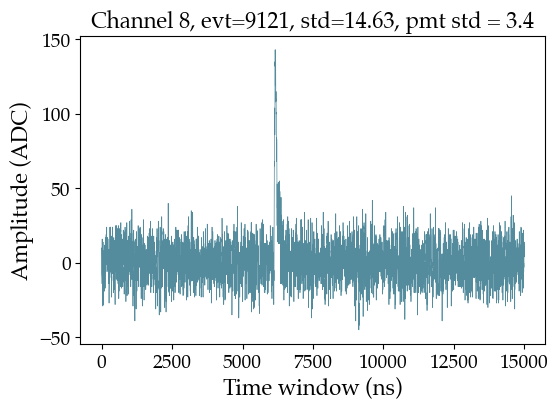

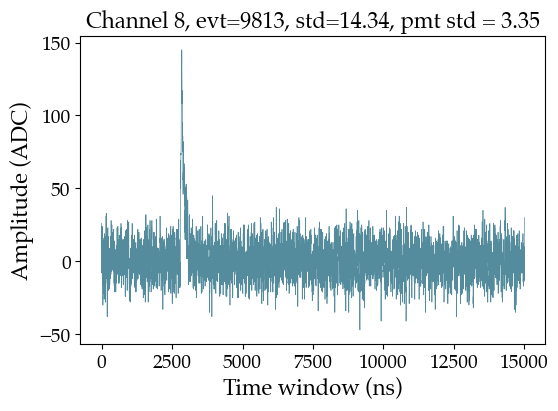

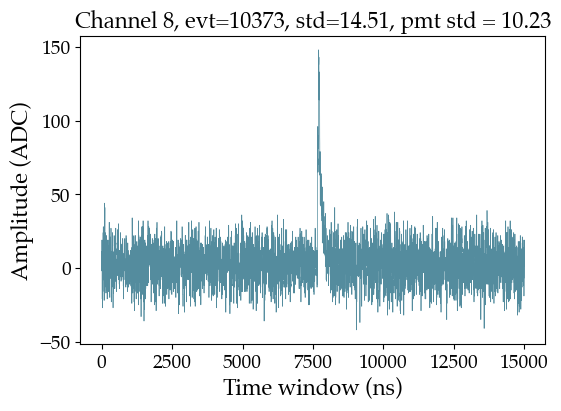

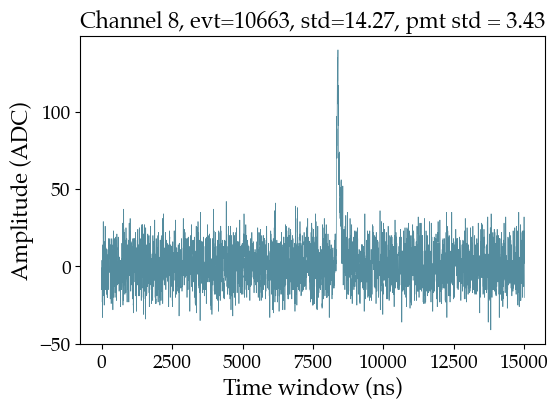

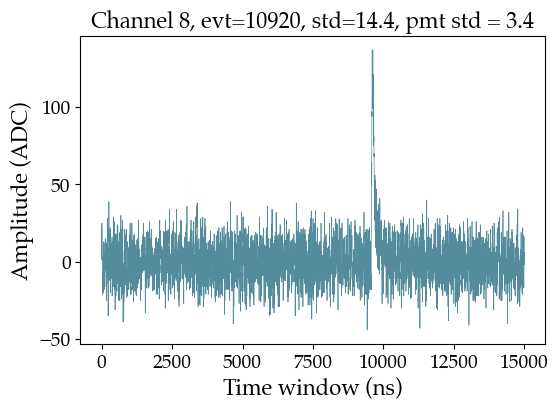

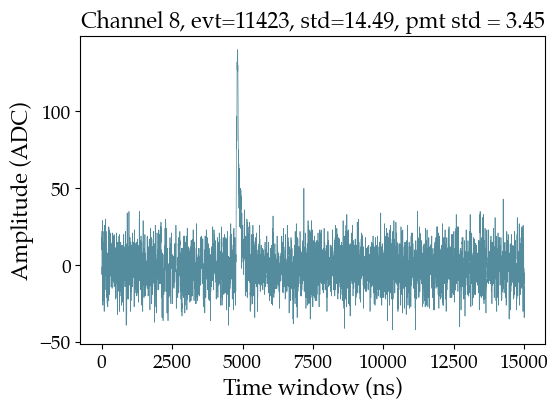

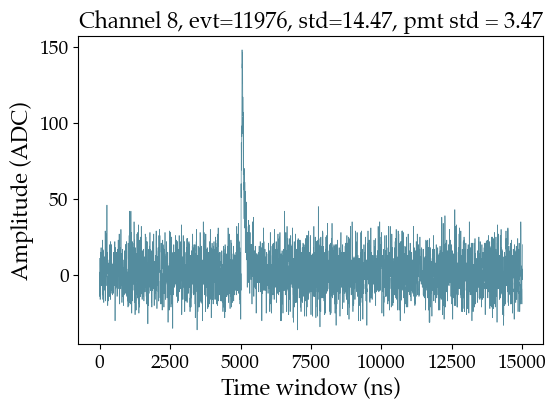

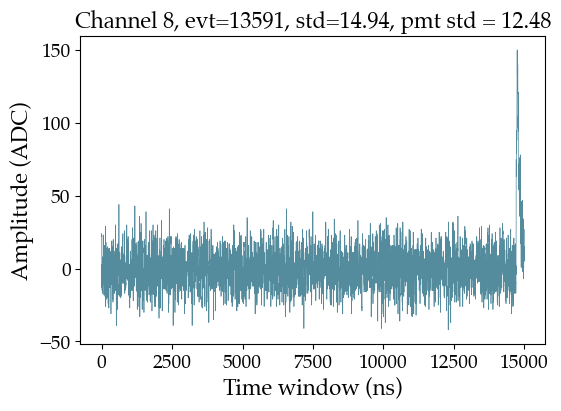

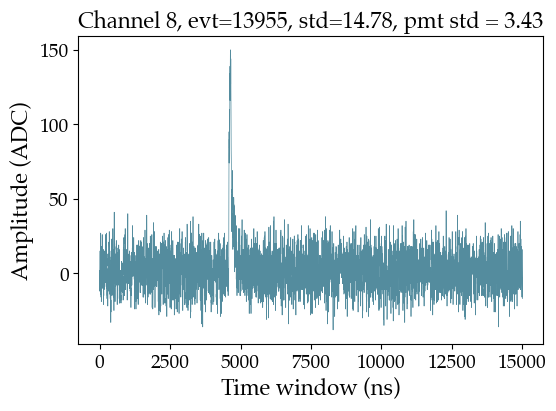

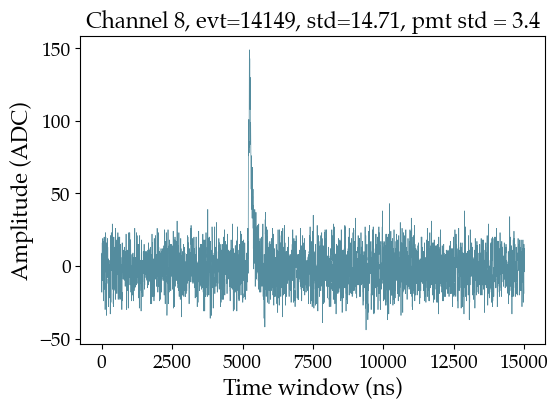

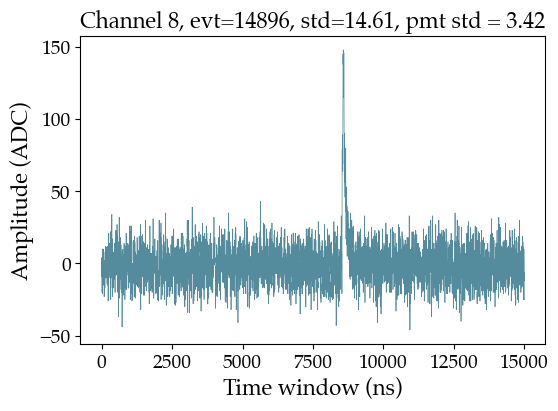

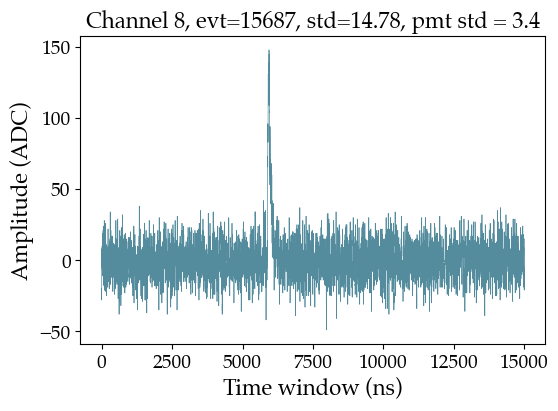

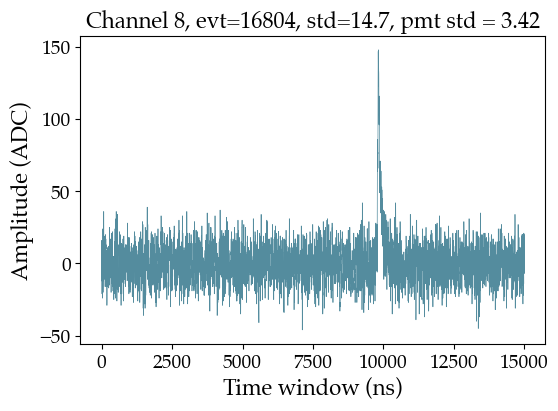

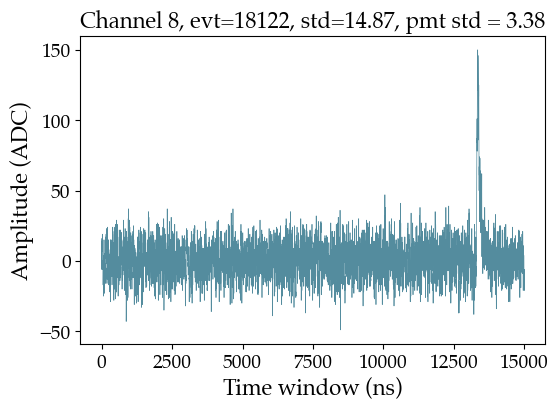

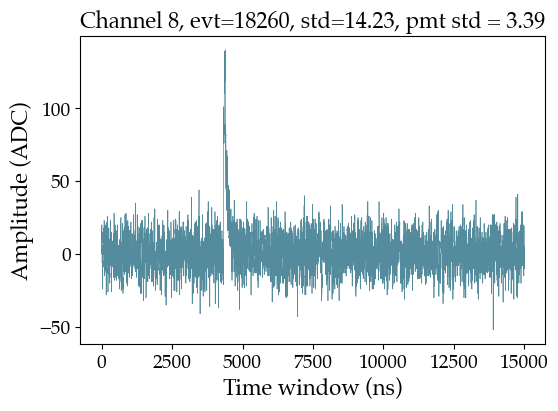

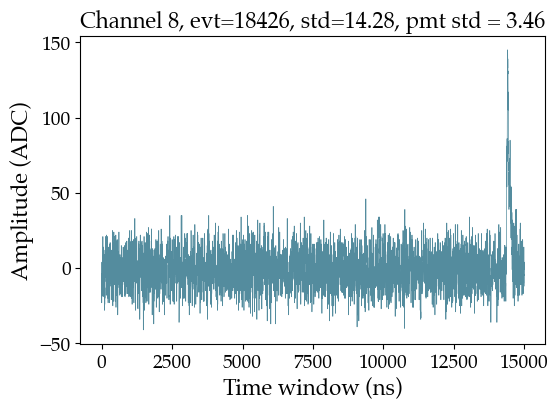

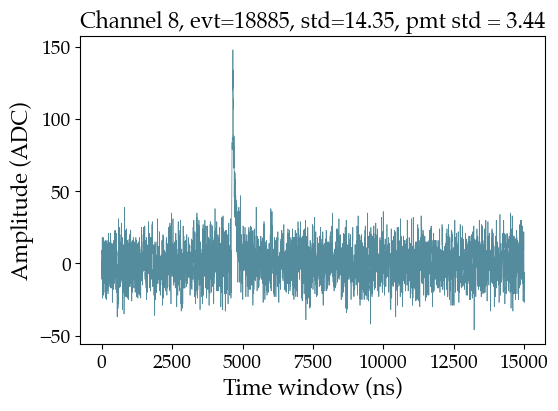

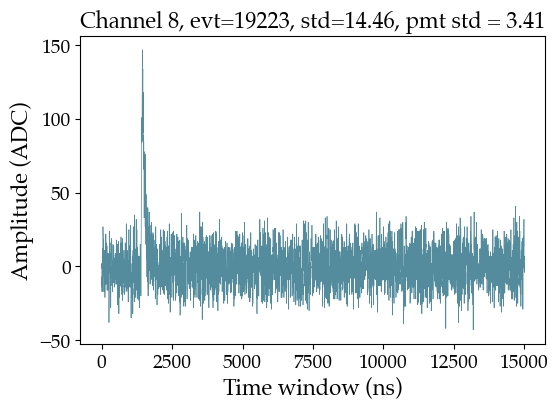

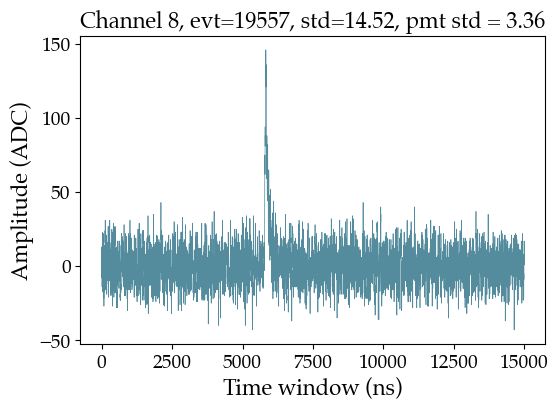

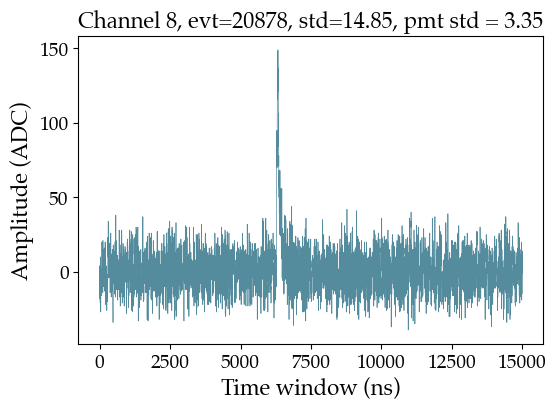

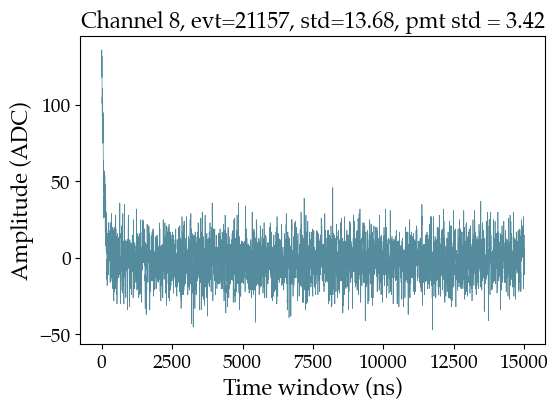

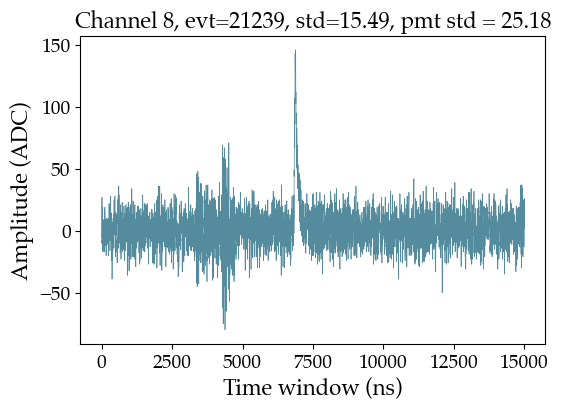

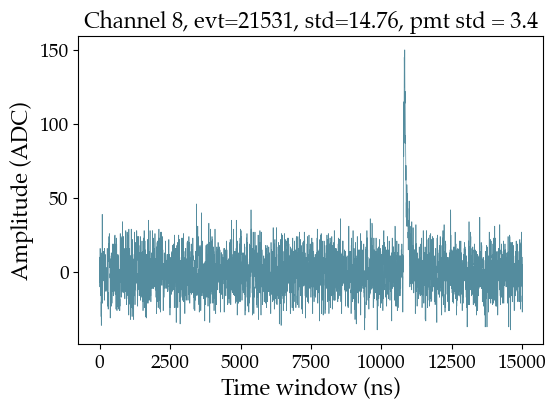

In [48]:
ch = 8

wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=False, wf_range_bsl=(0, 650))
for evt, wf in enumerate(swfs):
    if np.max(wf)>100 and np.max(wf)<150:
        pmt_std = np.std(np.array(RawTree[f'chan12/rdigi'].array())[evt])
        plt.figure(figsize=(6, 4))
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color=fav_col, alpha=0.9)
        plt.xlabel('Time window (ns)', fontsize=16)
        plt.ylabel('Amplitude (ADC)',  fontsize=16)
        plt.title(f"Channel {ch}, evt={evt}, std={np.round(np.std(wf), decimals=2)}, pmt std = {np.round(pmt_std, decimals=2)}", fontsize=16)
        plt.show()

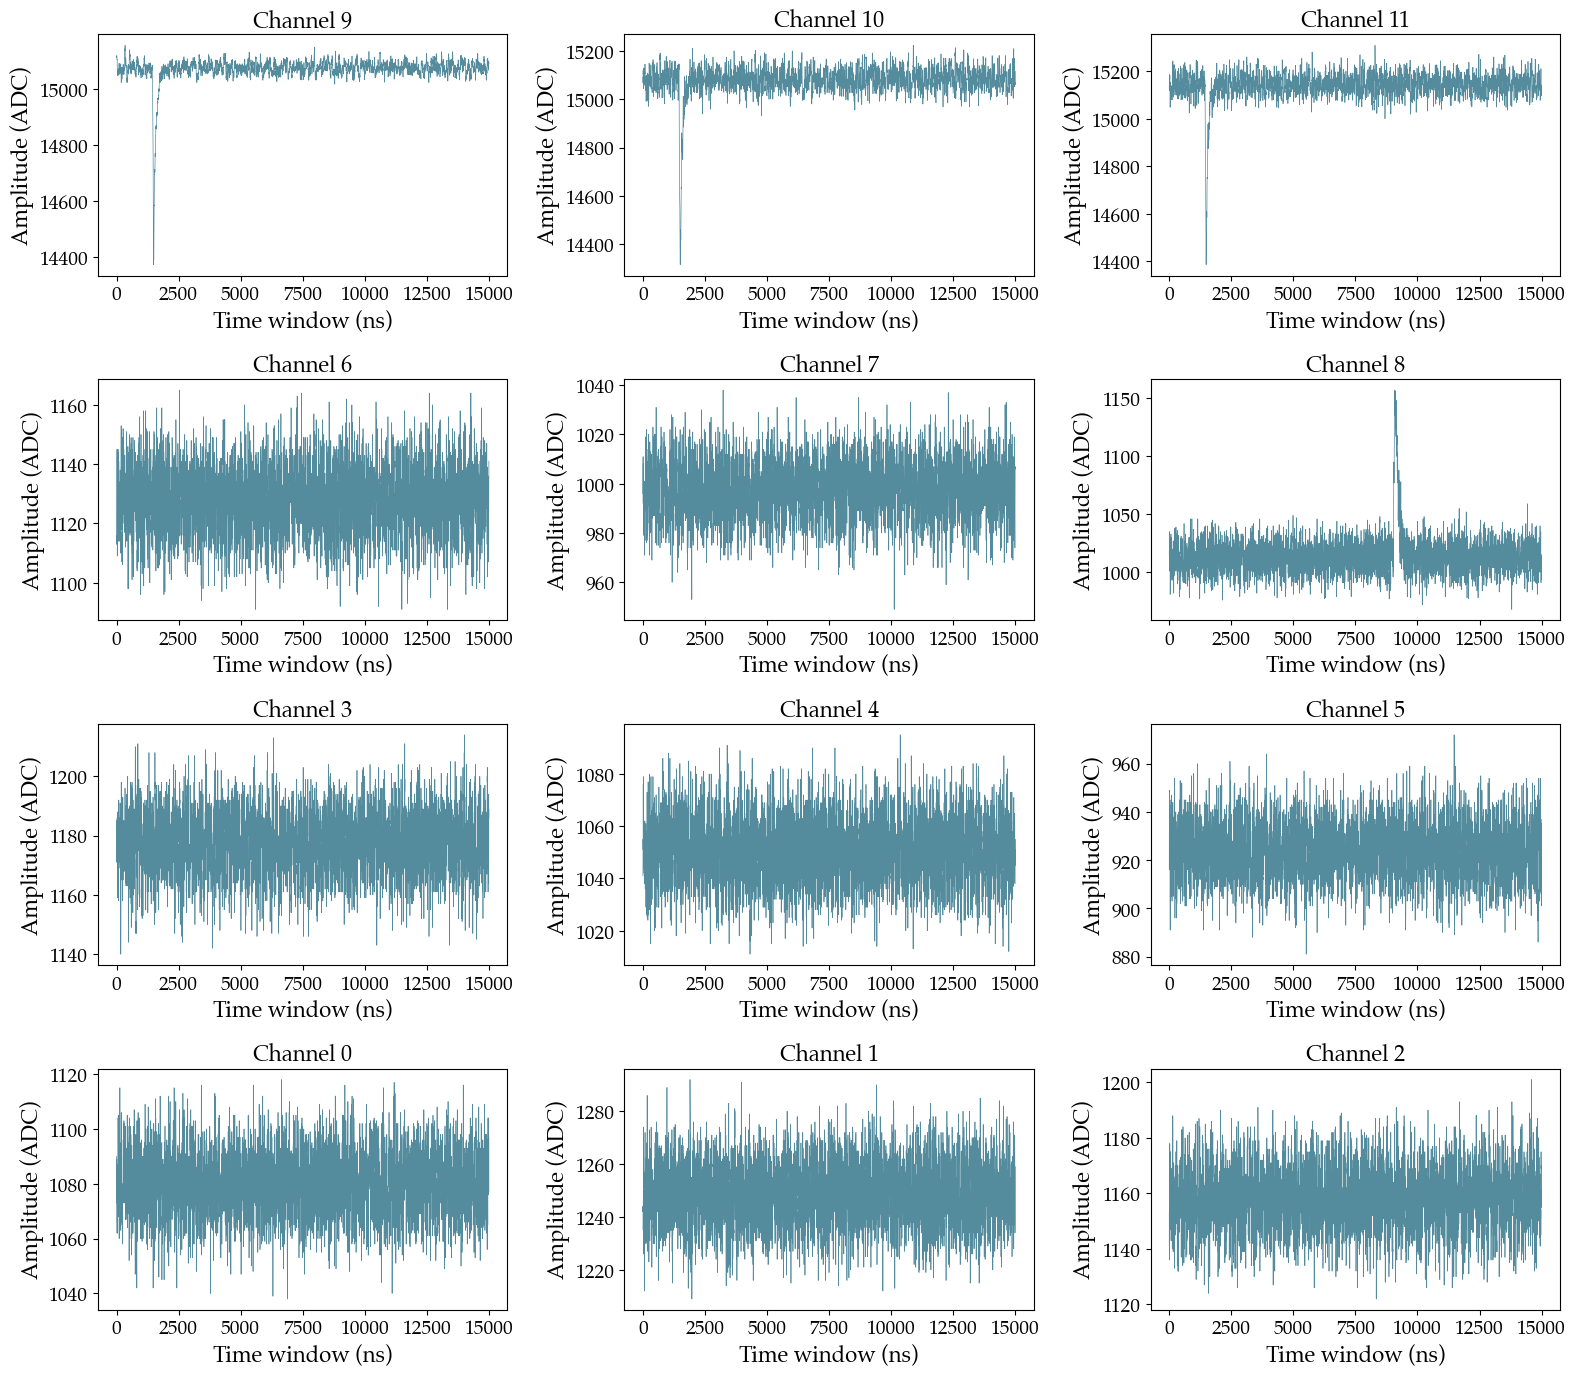

In [53]:
sel_evt  = 3072
fig, axs = plt.subplots(4, 3, figsize=(16, 14))
for row, ich in enumerate(reversed(np.arange(0, 12, 3))):
    for col in range(3):
        ch = ich + col
        wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[sel_evt]
        axs[row][col].plot(2*np.arange(len(wf)), wf, lw=0.5, color=fav_col, alpha=0.9)
        axs[row][col].set_xlabel('Time window (ns)', fontsize=16)
        axs[row][col].set_ylabel('Amplitude (ADC)',  fontsize=16)
        axs[row][col].set_title(f"Channel {ch}",     fontsize=16)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/rawdata_sipms.pdf', bbox_inches='tight')
plt.show()

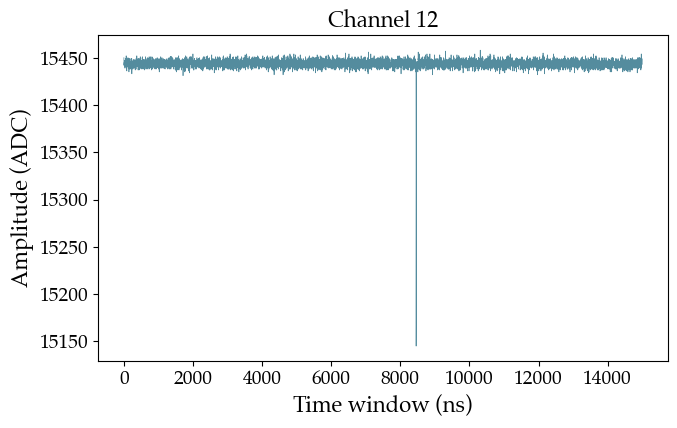

In [57]:
sel_evt  = 3072
ch = 12
wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[sel_evt]
plt.figure(figsize=(7, 4.5))
plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color=fav_col, alpha=0.9)
plt.xlabel('Time window (ns)', fontsize=16)
plt.ylabel('Amplitude (ADC)',  fontsize=16)
plt.title(f"Channel {ch}",     fontsize=16)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/rawdata_pmt.pdf', bbox_inches='tight')
plt.show()

#### The trigger SiPMs always have signal (and it is negative due to their electronics), whereas the other SiPMs not always detect peaks (when this happens, only baseline is observed).

#### Let's look for an event with peaks in several SiPMs:

In [8]:
### Get the events with signal using the standard deviation:

all_chs_good_evts = []
for ch in range(9):
    all_chs_good_evts.append(np.where(np.std(np.array(RawTree[f'chan{ch}/rdigi'].array()), axis=1)>13)[0])
    

### Get the common good events to plot an event with multiple peaks

common_good_evts = set(all_chs_good_evts[0])
for ch_good_evts in [all_chs_good_evts[3], all_chs_good_evts[6]]:
    common_good_evts = set(all_chs_good_evts[0]).intersection(ch_good_evts)

common_good_evts = list(common_good_evts)

print("Common good events across channels:", common_good_evts)

Common good events across channels: [4354, 15618, 12805, 5511, 1674, 19338, 20746, 5015, 7576, 18072, 19735, 14110, 10019, 15910, 16167, 2602, 2091, 13950, 18350, 13746, 15411, 6068, 9141, 14774, 2359, 17464, 14009, 11836, 4542, 19323, 7364, 3014, 14791, 10187, 6732, 7244, 11340, 18765, 2513, 6610, 11093, 6358, 2648, 473, 2905, 4443, 8027, 9949, 14433, 1253, 13669, 13926, 3306, 12650, 3566, 13936, 2804, 7289, 9595, 19709, 4862, 15615]


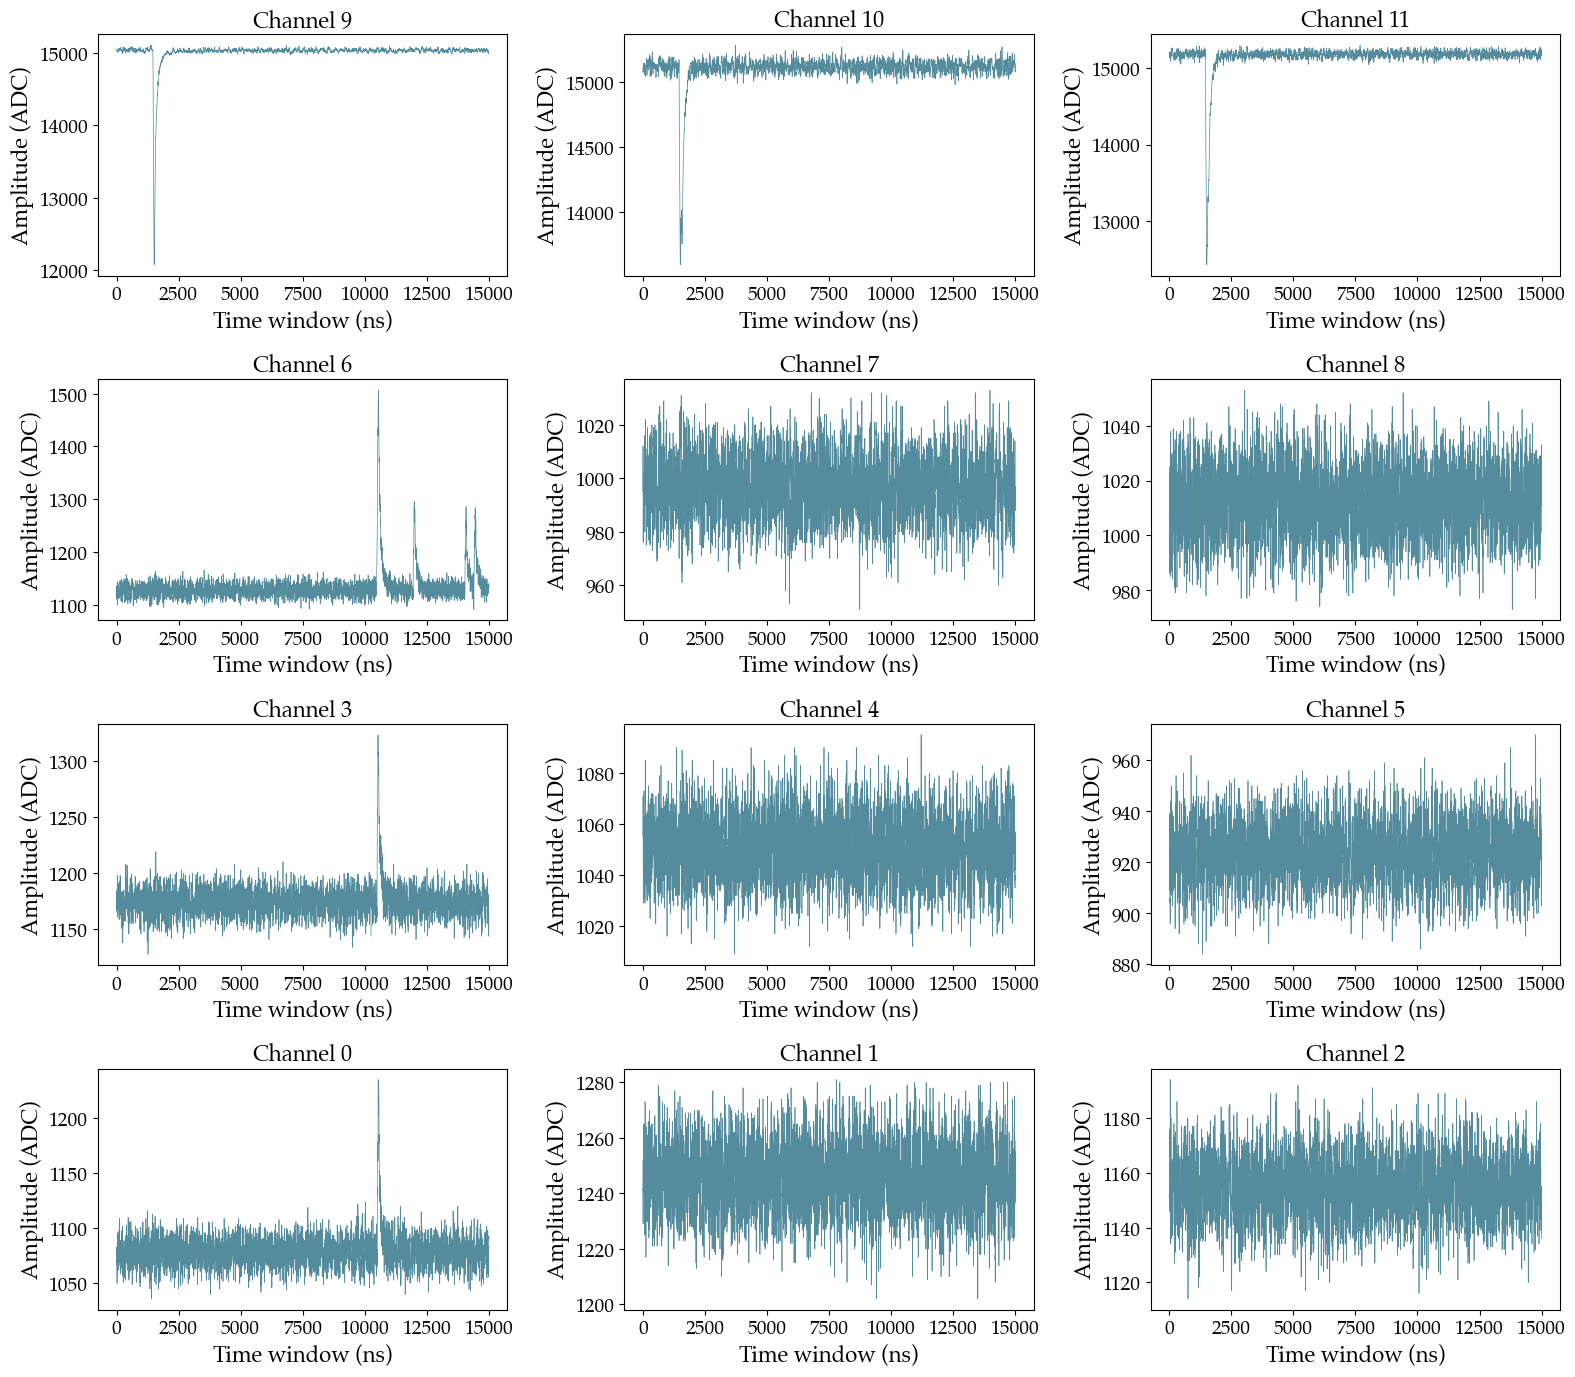

In [9]:
sel_evt  = 4354
fig, axs = plt.subplots(4, 3, figsize=(16, 14))
for row, ich in enumerate(reversed(np.arange(0, 12, 3))):
    for col in range(3):
        ch = ich + col
        wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[sel_evt]
        axs[row][col].plot(2*np.arange(len(wf)), wf, lw=0.5, color=fav_col, alpha=0.9)
        axs[row][col].set_xlabel('Time window (ns)', fontsize=16)
        axs[row][col].set_ylabel('Amplitude (ADC)',  fontsize=16)
        axs[row][col].set_title(f"Channel {ch}",     fontsize=16)
plt.tight_layout()
plt.show()

## Sum waveforms from the different channels:
One of the first interesting things to look at is the sum of the waveforms

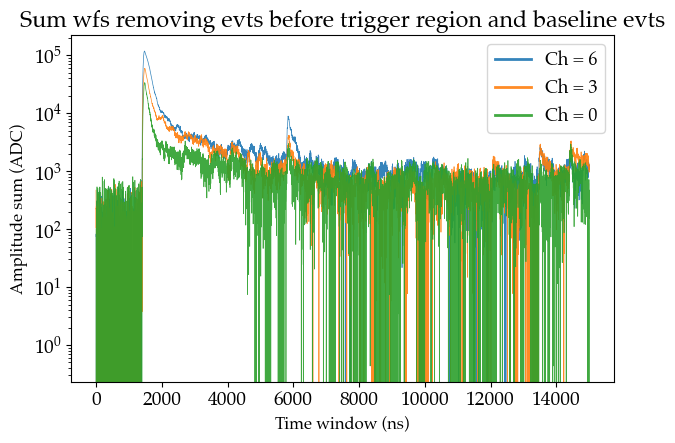

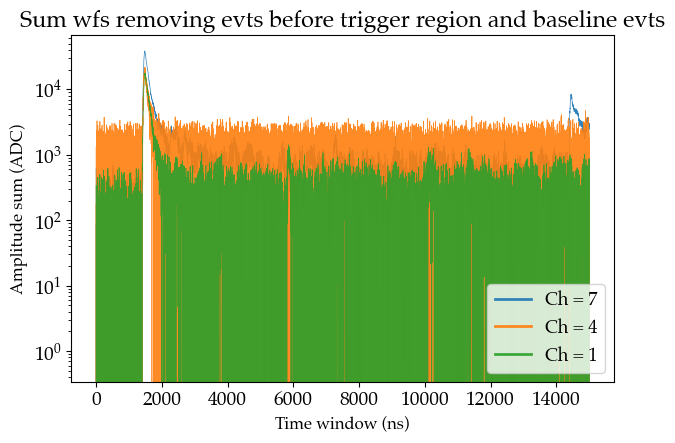

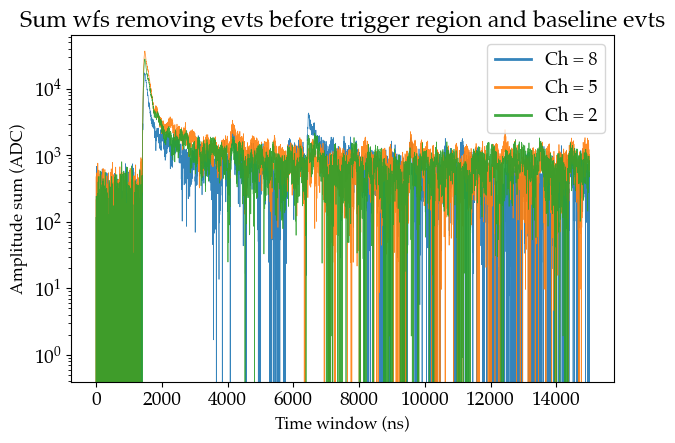

In [10]:
for some_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    plt.figure(figsize=(7, 4.5))
    for ch in some_chs:
        all_wfs          = np.array(RawTree[f'chan{ch}/rdigi'].array())
        all_wfs_rem_bckg = np.array([wf for wf in all_wfs          if np.std(wf[:650])<12]) ## Way to remove bckg before the trigger time
        all_wfs_rem_bsl  = np.array([wf for wf in all_wfs_rem_bckg if np.std(wf)      >12]) ## Way to remove baseline events
        subt_wfs         = pf.subtract_baseline(all_wfs_rem_bsl, mode=False, wf_range_bsl=(0, 650))
        sum_wfs          = np.sum(subt_wfs, axis=0)

        plt.plot(2*np.arange(len(sum_wfs)), sum_wfs, lw=0.5, label=f'Ch = {ch}', alpha=0.9)
    plt.title('Sum wfs removing evts before trigger region and baseline evts')
    plt.xlabel('Time window (ns)',    fontsize=12)
    plt.ylabel('Amplitude sum (ADC)', fontsize=12)
    plt.yscale('log')
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
    plt.plot

## Compute and subtract baseline

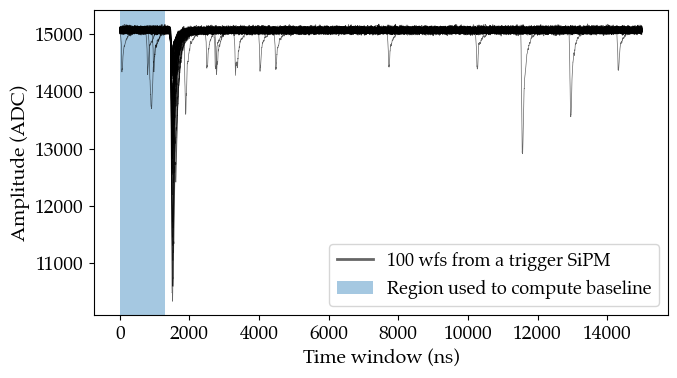

In [11]:
### Region used to compute baseline (using trigger SiPMs)

sel_ch = 9
wfs    = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[:100]
fig    = plt.figure(figsize=(7, 4))
for i, wf in enumerate(wfs):
    if i==0:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k', alpha=0.6, label='100 wfs from a trigger SiPM')
        plt.axvspan(0, 1300, alpha=0.4, label='Region used to compute baseline')
    else:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k', alpha=0.6)
        
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADC)',  fontsize=14)
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/Baseline_region.pdf', bbox_inches='tight')
plt.show()

## Compute the trigger time

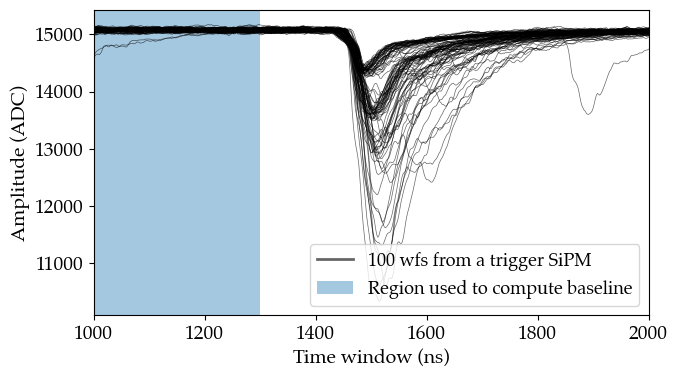

In [12]:
### Region used to compute baseline (using trigger SiPMs)

sel_ch = 9
wfs    = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[:100]
fig    = plt.figure(figsize=(7, 4))
for i, wf in enumerate(wfs):
    if i==0:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k', alpha=0.6, label='100 wfs from a trigger SiPM')
        plt.axvspan(0, 1300, alpha=0.4, label='Region used to compute baseline')
    else:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k', alpha=0.6)
        
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADC)',  fontsize=14)
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
    plt.xlim(1000, 2000)
plt.tight_layout()
plt.show()

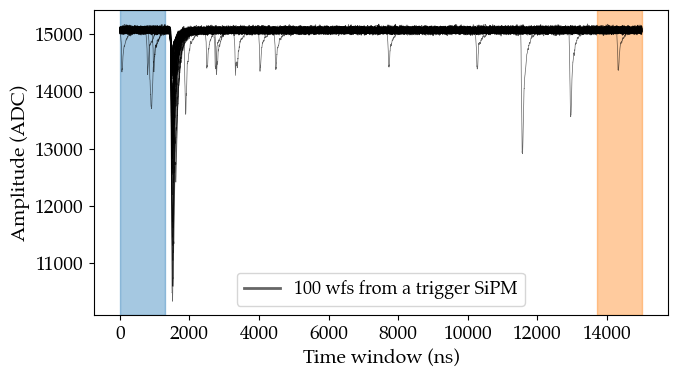

In [13]:
sel_ch = 9
wfs    = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[:100]
fig    = plt.figure(figsize=(7, 4))
for i, wf in enumerate(wfs):
    if i==0:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k', alpha=0.6, label='100 wfs from a trigger SiPM')
        plt.axvspan(0,           1300, alpha=0.4, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
        plt.axvspan(15000-1300, 15000, alpha=0.4, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    else:
        plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color='k', alpha=0.6)
        
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADC)',  fontsize=14)
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
plt.show()

#### Baseline subtraction using the mean

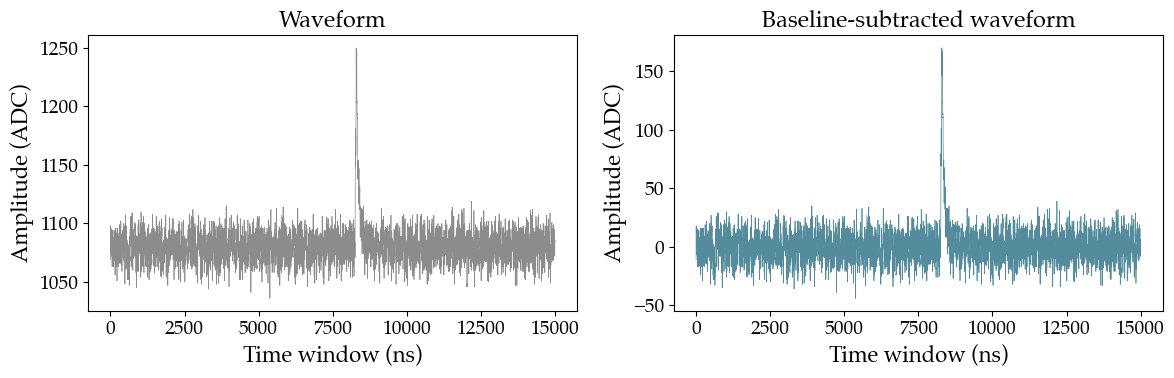

In [14]:
sel_ch     = 0
sel_evt    = 15
one_wf_ch  = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax,wf,col,lab) in enumerate(zip(axs,[one_wf_ch,subt_wf_ch],['grey', fav_col],['Waveform','Baseline-subtracted waveform'])):
    ax.plot(2*np.arange(len(wf)), wf, lw=0.5, color=col, alpha=0.9)
    ax.set_xlabel('Time window (ns)', fontsize=16)
    ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
    ax.set_title(lab)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/Baseline_subtraction_wf.pdf', bbox_inches='tight')
plt.show()

## Apply the Savinsky-Golay filter to remove the noise

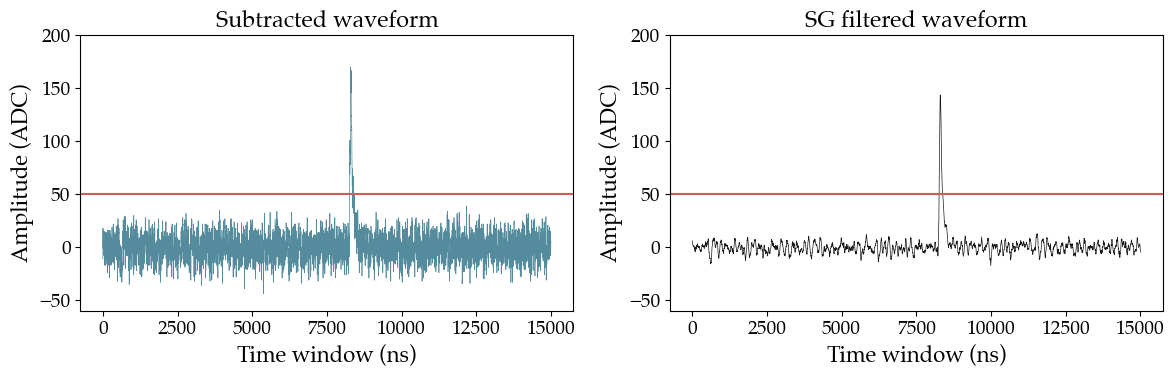

In [16]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax,wf,col,lab) in enumerate(zip(axs,[subt_wf_ch,filt_swf_ch],[fav_col,'k'],['Subtracted waveform', 'SG filtered waveform'])):
    ax.plot(2*np.arange(len(wf)),  wf,  lw=0.5, color=col, alpha=0.9)
    ax.axhline(y=sel_thr, color='indianred')
    ax.set_xlabel('Time window (ns)', fontsize=16)
    ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
    ax.set_title(lab)
    ax.set_ylim(-60, 200)
    ax.set_ylim(-60, 200)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/SG_filter_wf.pdf', bbox_inches='tight')
plt.show()

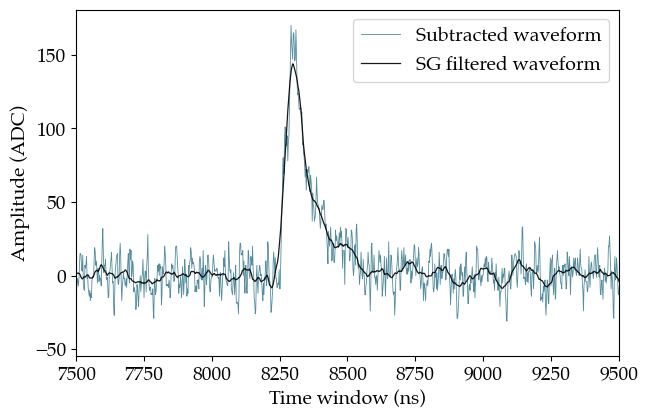

In [29]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(2*np.arange(len(subt_wf_ch)),  subt_wf_ch,  lw=0.6, color=fav_col, alpha=0.9, label='Subtracted waveform')
plt.plot(2*np.arange(len(filt_swf_ch)), filt_swf_ch, lw=0.9, color='k',     alpha=0.9, label='SG filtered waveform')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(7500, 9500)
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/SG_filter_wf_close.pdf', bbox_inches='tight')
plt.show()

## Noise suppression

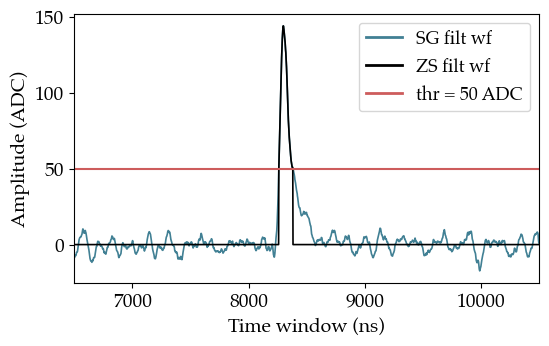

In [101]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(filt_swf_ch)), filt_swf_ch, lw=1.2, color=fav_col, label='SG filt wf')
plt.plot(2*np.arange(len(zs_filt_wf)),  zs_filt_wf,  lw=1.2, color='k',     label='ZS filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(6500, 10500)
leg = plt.legend(fontsize=13)
for line in leg.get_lines():
    line.set_linewidth(2)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform.pdf', bbox_inches='tight')
plt.show()

## Get peaks above threshold using peakutils:

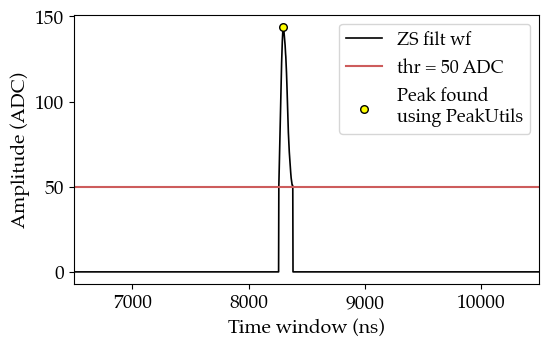

In [16]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(zs_filt_wf)), zs_filt_wf, lw=1.2, color='k', label='ZS filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(6500, 10500)
plt.legend(fontsize=13)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform_peaks.pdf', bbox_inches='tight')
plt.show()

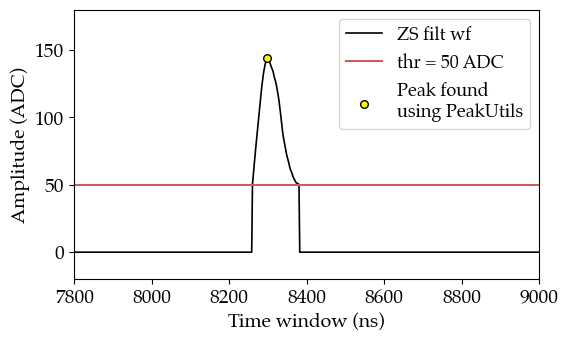

In [108]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(zs_filt_wf)), zs_filt_wf, lw=1.2, color='k', label='ZS filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(7800, 9000)
plt.ylim(-20, 180)
plt.legend(fontsize=13)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform_peaks.pdf', bbox_inches='tight')
plt.show()

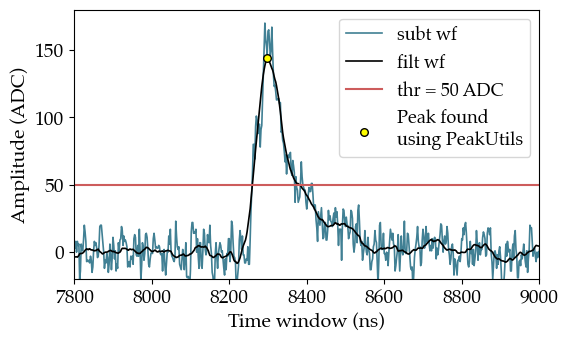

In [109]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(subt_wf_ch)),  subt_wf_ch,  lw=1.2, color=fav_col, label='subt wf')
plt.plot(2*np.arange(len(filt_swf_ch)), filt_swf_ch, lw=1.2, color='k', label='filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(7800, 9000)
plt.ylim(-20, 180)
plt.legend(fontsize=13)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform_peaks.pdf', bbox_inches='tight')
plt.show()

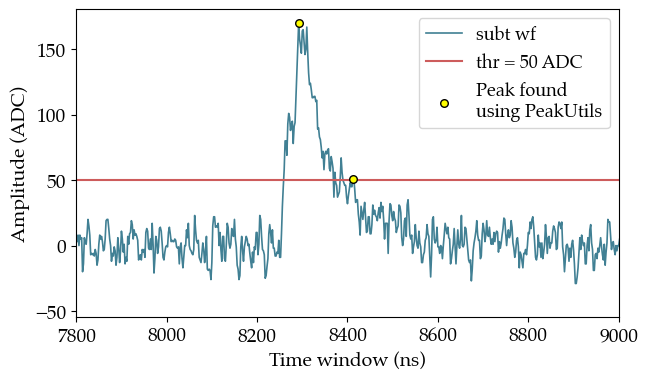

In [18]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
zs_filt_wf  = pf.noise_suppression(subt_wf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(7, 4))
plt.plot(2*np.arange(len(subt_wf_ch)), subt_wf_ch, lw=1.2, color=fav_col, label='subt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(7800, 9000)
plt.legend(fontsize=13)
plt.show()

## Look at the single pe events

In [114]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file_78.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

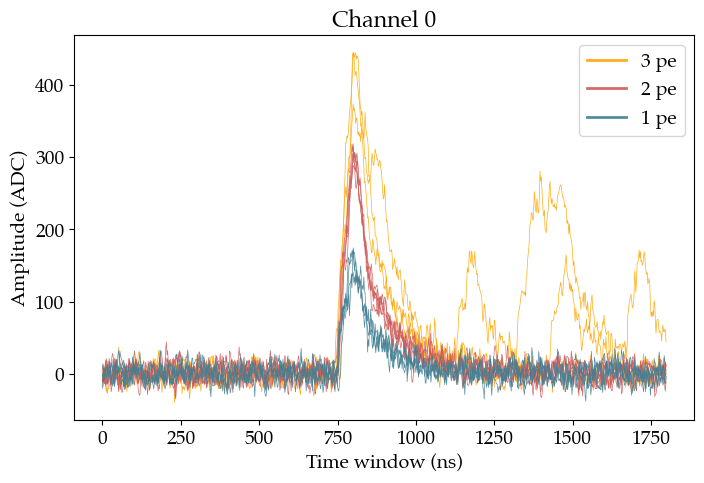

In [54]:
ch   = 0
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

fig, ax0 = plt.subplots(1, 1, figsize=(8,5))
for n_pe, rng, col in zip([3, 2, 1], [(350, 450), (200, 350), (100, 200)], ['orange', 'indianred', fav_col]):
    sel_swfs = (max_swfs > rng[0]) & (max_swfs < rng[1])
    swfs0    = swfs[sel_swfs]

    for i, wf in enumerate(swfs0[:5]):#[1, 3, 4, 5, 6, 7]]):
        if i==0:
            lab = f'{n_pe} pe'
        else:
            lab = ''
        ax0.plot(2*np.arange(len(wf[np.argmax(wf)-400:np.argmax(wf)+500])), wf[np.argmax(wf)-400:np.argmax(wf)+500], lw=0.5, color=col, alpha=0.9, label=lab)
ax0.set_title(f'Channel {ch}')
ax0.set_xlabel('Time window (ns)', fontsize=14)
ax0.set_ylabel('Amplitude (ADC)',  fontsize=14)
leg = ax0.legend()
for line in leg.get_lines():
    line.set_linewidth(2)

#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape.pdf', bbox_inches='tight')
plt.show()

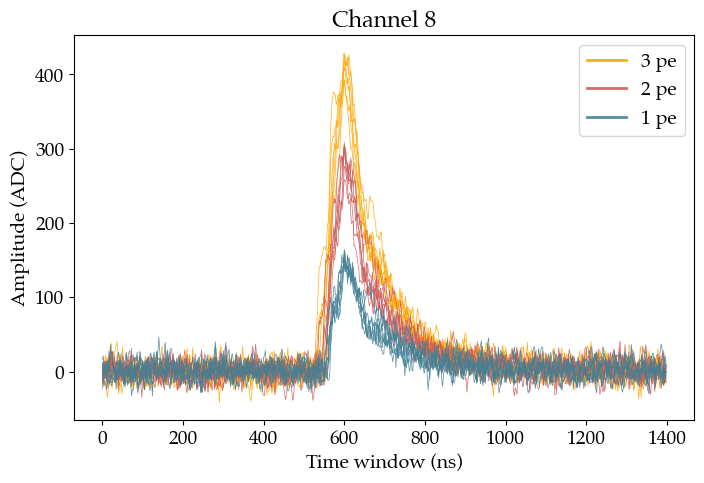

In [60]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

fig, ax0 = plt.subplots(1, 1, figsize=(8,5))
for n_pe, rng, col in zip([3, 2, 1], [(350, 450), (200, 350), (100, 200)], ['orange', 'indianred', fav_col]):
    sel_swfs = (max_swfs > rng[0]) & (max_swfs < rng[1])
    swfs0    = swfs[sel_swfs]

    for i, wf in enumerate(swfs0[:8]):
        if i==0:
            lab = f'{n_pe} pe'
        else:
            lab = ''
        ax0.plot(2*np.arange(len(wf[np.argmax(wf)-300:np.argmax(wf)+400])), wf[np.argmax(wf)-300:np.argmax(wf)+400], lw=0.5, color=col, alpha=0.9, label=lab)
ax0.set_title(f'Channel {ch}')
ax0.set_xlabel('Time window (ns)', fontsize=14)
ax0.set_ylabel('Amplitude (ADC)',  fontsize=14)
leg = ax0.legend()
for line in leg.get_lines():
    line.set_linewidth(2)

#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8.pdf', bbox_inches='tight')
plt.show()

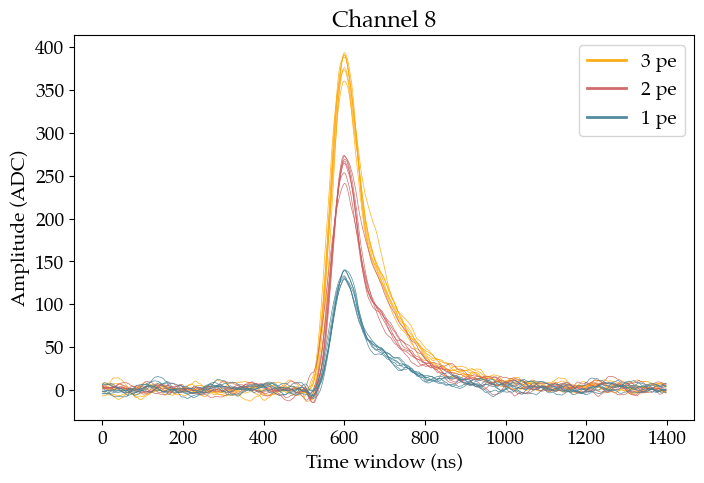

In [61]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

fig, ax0 = plt.subplots(1, 1, figsize=(8,5))
for n_pe, rng, col in zip([3, 2, 1], [(350, 450), (200, 350), (100, 200)], ['orange', 'indianred', fav_col]):
    sel_swfs = (max_swfs > rng[0]) & (max_swfs < rng[1])
    swfs0    = swfs[sel_swfs]

    for i, wf in enumerate(swfs0[:8]):
        if i==0:
            lab = f'{n_pe} pe'
        else:
            lab = ''
        wf = savgol_filter(wf, window_length=50, polyorder=3)
        ax0.plot(2*np.arange(len(wf[np.argmax(wf)-300:np.argmax(wf)+400])), wf[np.argmax(wf)-300:np.argmax(wf)+400], lw=0.5, color=col, alpha=0.9, label=lab)
ax0.set_title(f'Channel {ch}')
ax0.set_xlabel('Time window (ns)', fontsize=14)
ax0.set_ylabel('Amplitude (ADC)',  fontsize=14)
leg = ax0.legend()
for line in leg.get_lines():
    line.set_linewidth(2)

#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8_SG_filter.pdf', bbox_inches='tight')
plt.show()

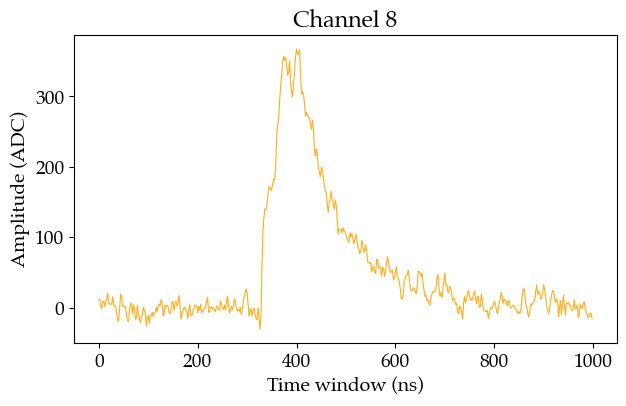

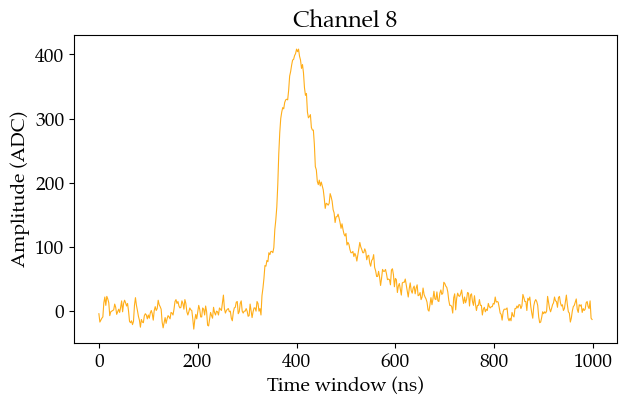

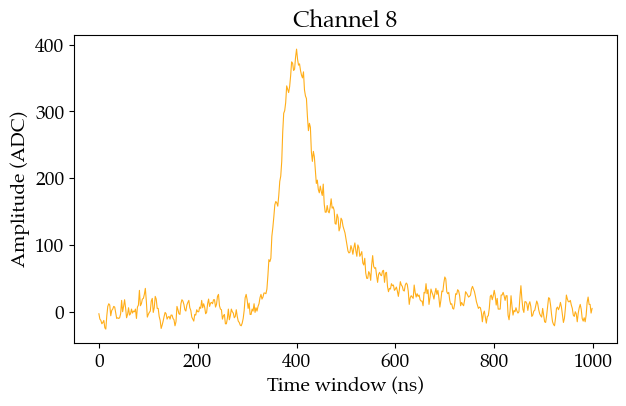

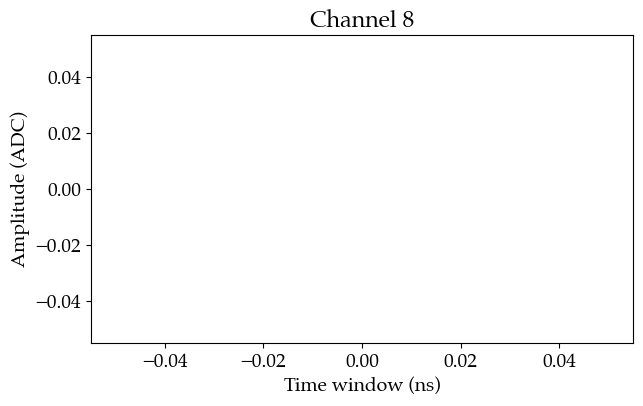

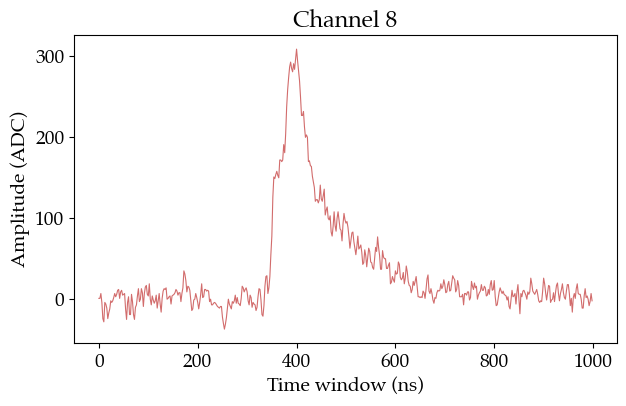

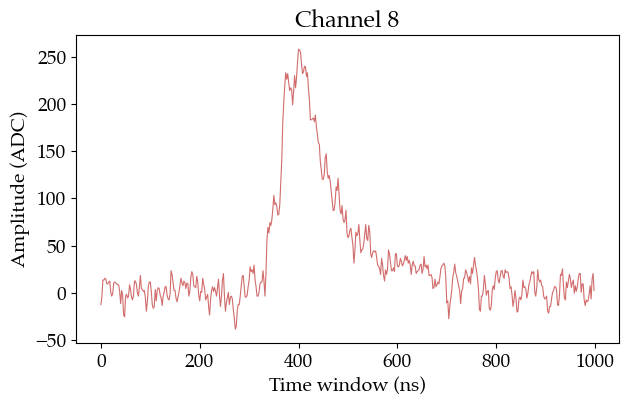

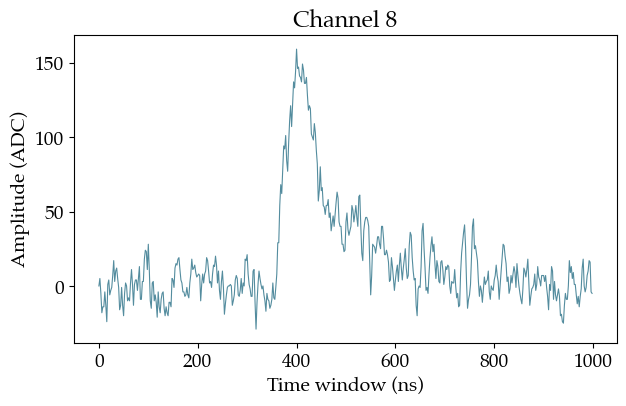

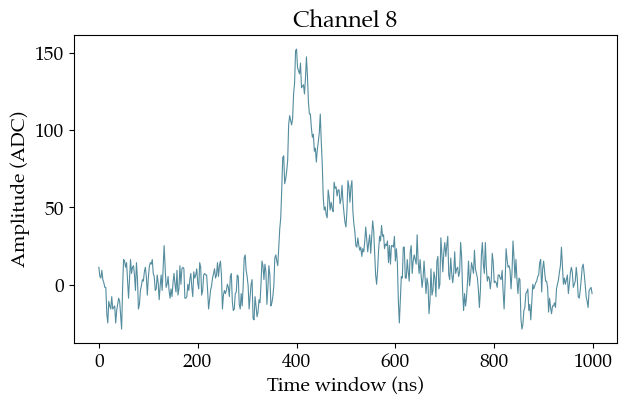

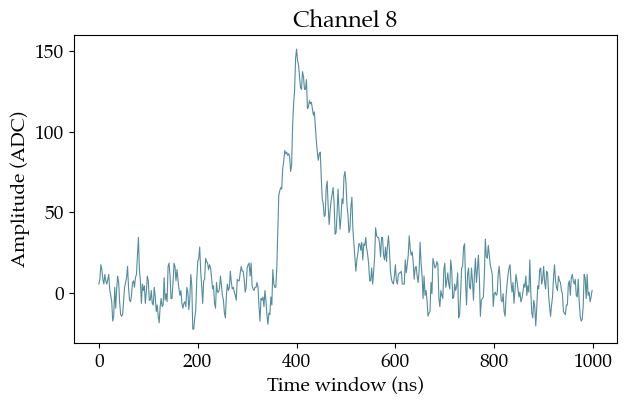

In [70]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

for n_pe, rng, col in zip([3, 2, 1], [(350, 450), (200, 350), (100, 200)], ['orange', 'indianred', fav_col]):
    sel_swfs = (max_swfs > rng[0]) & (max_swfs < rng[1])
    swfs0    = swfs[sel_swfs]

    for i, wf in enumerate(swfs0[:3]):
        plt.figure(figsize=(7, 4))
        plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), wf[np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color=col, alpha=0.9)
        plt.title(f'Channel {ch}')
        plt.xlabel('Time window (ns)', fontsize=14)
        plt.ylabel('Amplitude (ADC)',  fontsize=14)
        #plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8_SG_filter.pdf', bbox_inches='tight')
        plt.show()

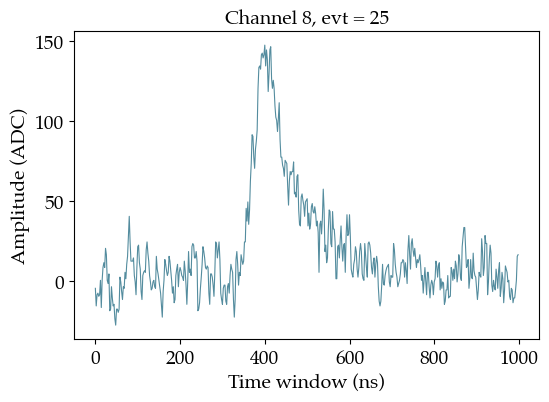

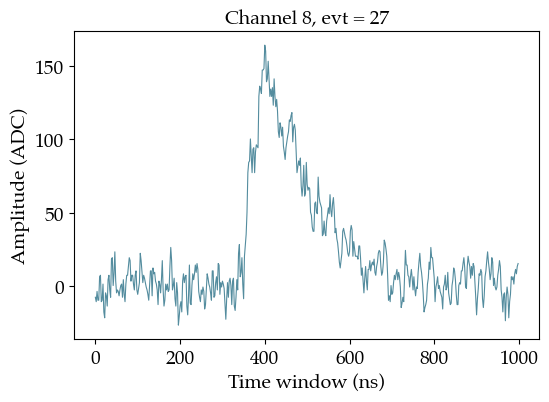

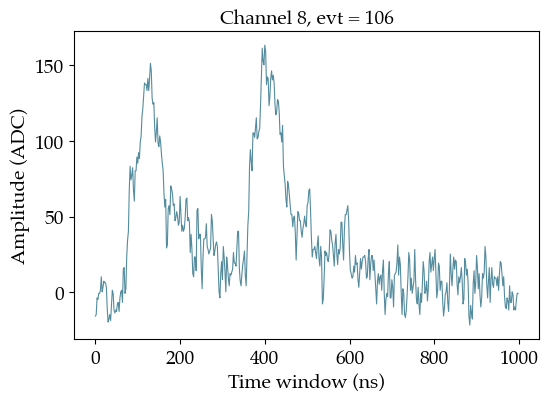

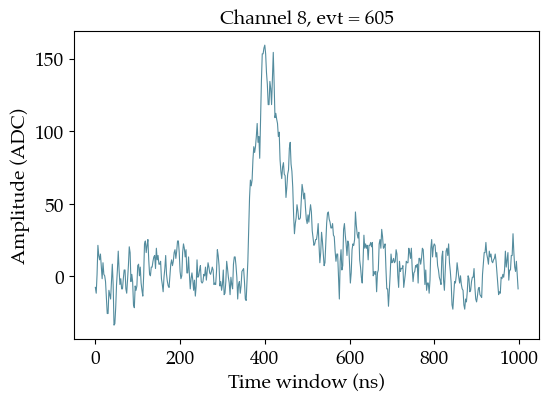

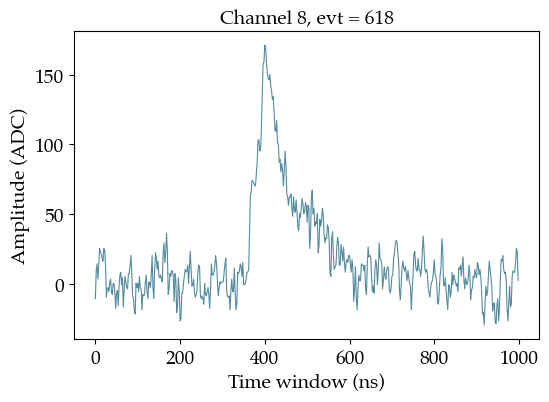

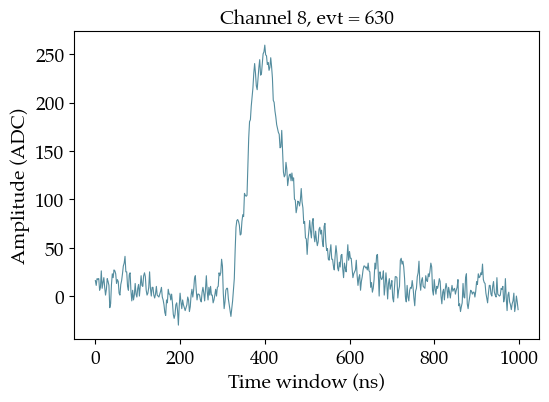

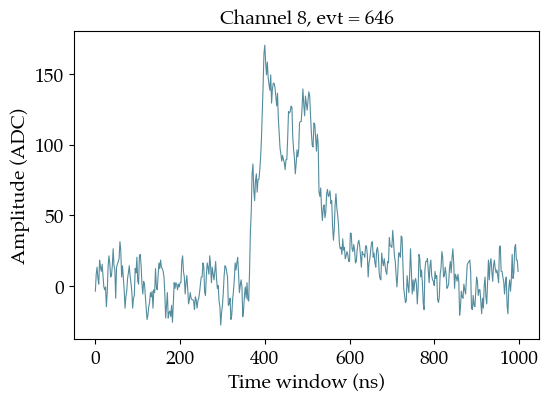

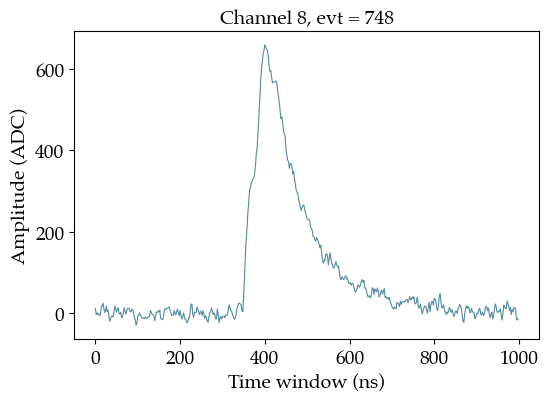

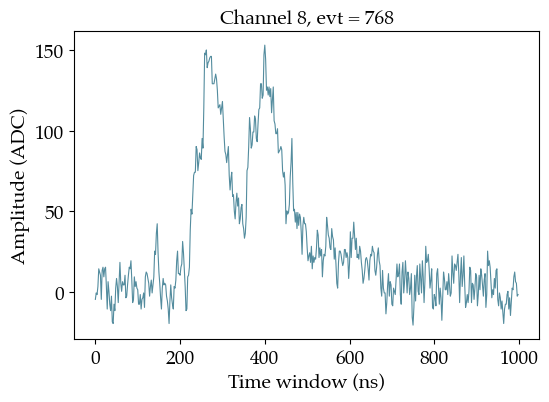

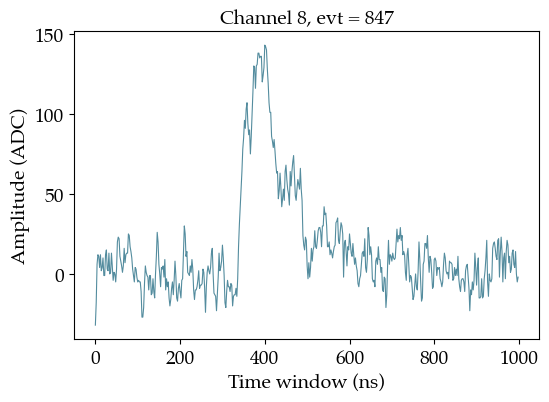

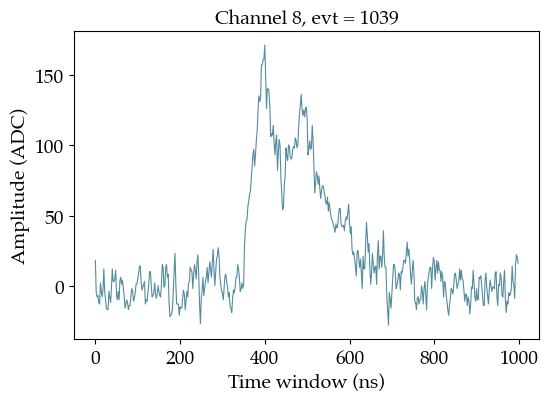

In [115]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

for i, (wf, mxwf) in enumerate(zip(swfs[:1500], max_swfs[:1500])):
    #if mxwf<100:
    #    continue
    if i in [25, 27, 106, 605, 618, 630, 646, 748, 768, 847, 1039]:
        sgwf = savgol_filter(wf, window_length=50, polyorder=3)
        plt.figure(figsize=(6, 4))
        plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), wf  [np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color=fav_col, alpha=0.9)
        #plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), sgwf[np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color='k', alpha=0.9)
        plt.title(f'Channel {ch}, evt = {i}', fontsize=14)
        plt.xlabel('Time window (ns)', fontsize=14)
        plt.ylabel('Amplitude (ADC)',  fontsize=14)
        #plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8_SG_filter.pdf', bbox_inches='tight')
        plt.show()

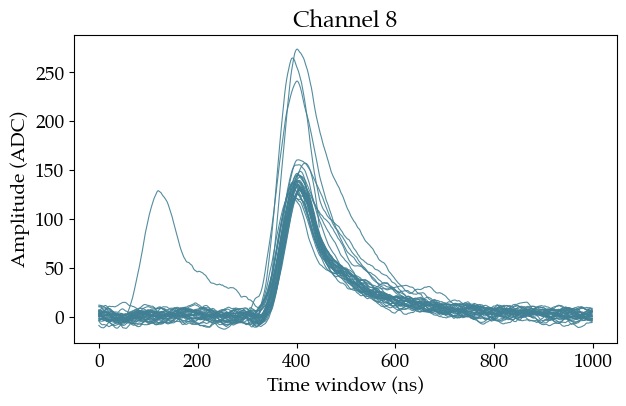

In [77]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

plt.figure(figsize=(7, 4))
for i, wf in enumerate(swfs[:200]):
    if max_swfs[i]<100:
        continue
    sgwf = savgol_filter(wf, window_length=50, polyorder=3)
    plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), sgwf[np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color=fav_col, alpha=0.9)
plt.title(f'Channel {ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8_SG_filter.pdf', bbox_inches='tight')
plt.show()

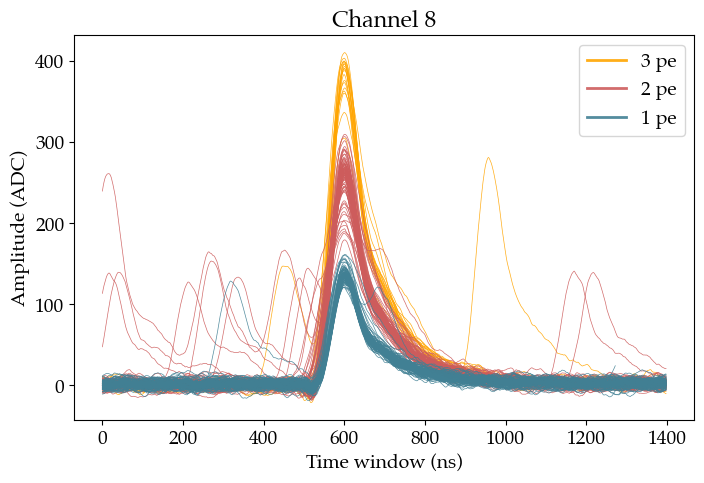

In [75]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

fig, ax0 = plt.subplots(1, 1, figsize=(8,5))
for n_pe, rng, col in zip([3, 2, 1], [(350, 450), (200, 350), (100, 200)], ['orange', 'indianred', fav_col]):
    sel_swfs = (max_swfs > rng[0]) & (max_swfs < rng[1])
    swfs0    = swfs[sel_swfs]

    for i, wf in enumerate(swfs0[:100]):
        if i==0:
            lab = f'{n_pe} pe'
        else:
            lab = ''
        wf = savgol_filter(wf, window_length=50, polyorder=3)
        ax0.plot(2*np.arange(len(wf[np.argmax(wf)-300:np.argmax(wf)+400])), wf[np.argmax(wf)-300:np.argmax(wf)+400], lw=0.5, color=col, alpha=0.9, label=lab)
ax0.set_title(f'Channel {ch}')
ax0.set_xlabel('Time window (ns)', fontsize=14)
ax0.set_ylabel('Amplitude (ADC)',  fontsize=14)
leg = ax0.legend()
for line in leg.get_lines():
    line.set_linewidth(2)

#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8_SG_filter.pdf', bbox_inches='tight')
plt.show()

## Comparison between SG and Wiener filters:

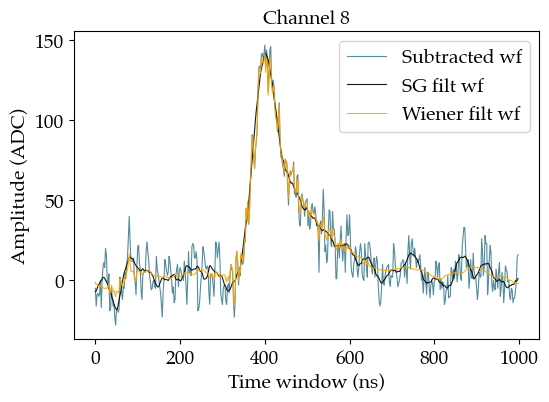

In [122]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=False, wf_range_bsl=(0, 650))
max_swfs = np.max(swfs, axis=1)
wf = swfs[25]

sgwf = savgol_filter(wf, window_length=30, polyorder=3)
wwf  = wiener       (wf, mysize=50)

plt.figure(figsize=(6, 4))
plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), wf  [np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color=fav_col,  alpha=0.9, label='Subtracted wf')
plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), sgwf[np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color='k',      alpha=0.9, label='SG filt wf')
plt.plot(2*np.arange(len(wf[np.argmax(wf)-200:np.argmax(wf)+300])), wwf [np.argmax(wf)-200:np.argmax(wf)+300], lw=0.8, color='orange', alpha=0.9, label='Wiener filt wf')
plt.title(f'Channel {ch}', fontsize=14)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/single_pe_shape_ch8_SG_and_Wiener_filter.pdf', bbox_inches='tight')
plt.show()

## All analysis steps for a trigger SiPM

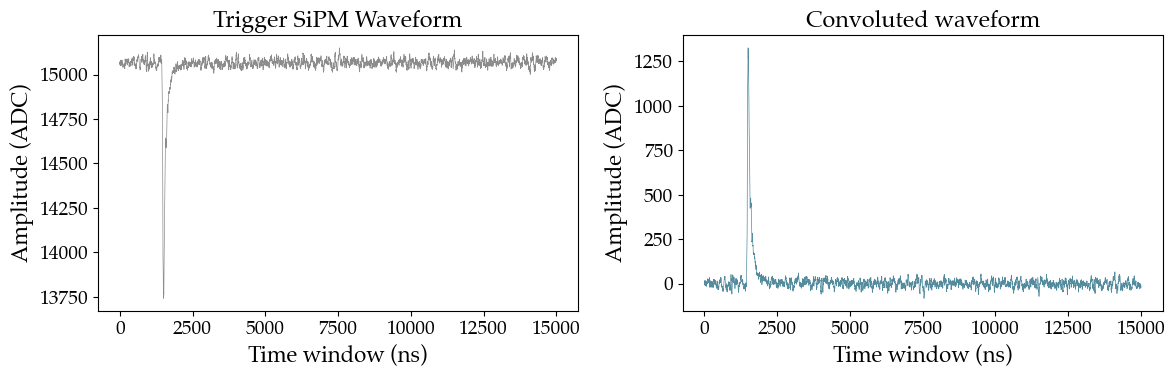

In [129]:
sel_ch    = 9
sel_evt   = 1
one_wf_ch = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
cwf_ch    = blr.pmt_deconvolver(one_wf_ch, wf_range_bsl=(0, 650))
fig, axs  = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax,wf,col,lab) in enumerate(zip(axs,[one_wf_ch, cwf_ch],['grey', fav_col],['Trigger SiPM Waveform','Convoluted waveform'])):
    ax.plot(2*np.arange(len(wf)), wf, lw=0.5, color=col, alpha=0.9)
    ax.set_xlabel('Time window (ns)', fontsize=16)
    ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
    ax.set_title(lab)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/Trigger_SiPM_conv_wf.pdf', bbox_inches='tight')
plt.show()

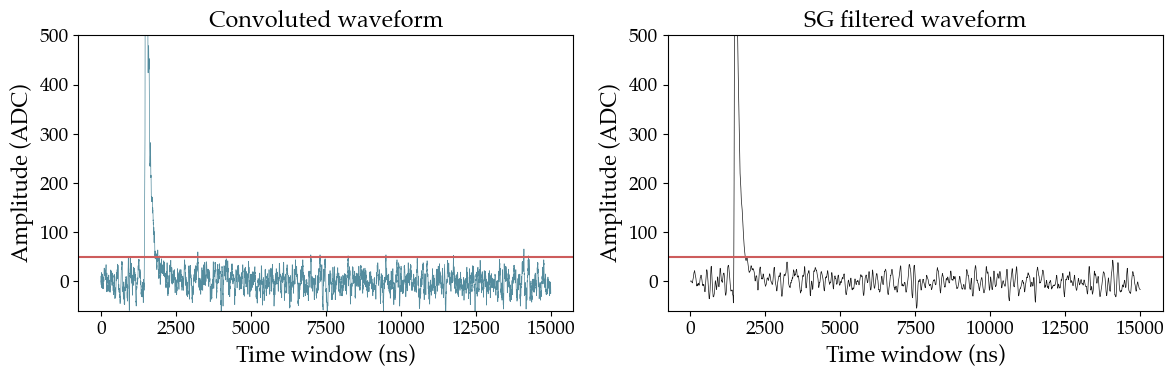

In [132]:
sel_ch      = 9
sel_evt     = 1
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
cwf_ch      = blr.pmt_deconvolver(one_wf_ch, wf_range_bsl=(0, 650))
filt_cwf_ch = savgol_filter(cwf_ch, window_length=50, polyorder=3)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax,wf,col,lab) in enumerate(zip(axs,[cwf_ch,filt_cwf_ch],[fav_col,'k'],['Convoluted waveform', 'SG filtered waveform'])):
    ax.plot(2*np.arange(len(wf)),  wf,  lw=0.5, color=col, alpha=0.9)
    ax.axhline(y=sel_thr, color='indianred')
    ax.set_xlabel('Time window (ns)', fontsize=16)
    ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
    ax.set_title(lab)
    ax.set_ylim(-60, 500)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/SF_filter_wf_trigger_SiPM.pdf', bbox_inches='tight')
plt.show()

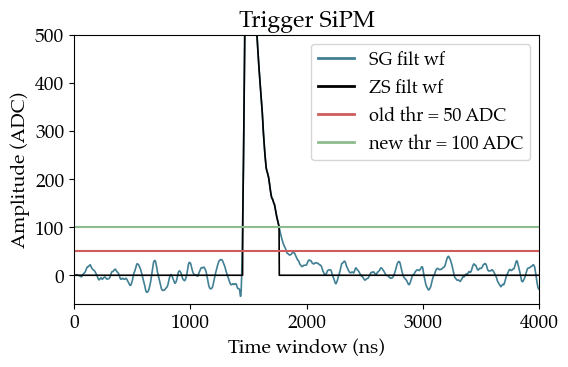

In [140]:
sel_ch        = 9
sel_evt       = 1
sel_trigg_thr = 100 #ADC
one_wf_ch     = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
cwf_ch        = blr.pmt_deconvolver(one_wf_ch, wf_range_bsl=(0, 650))
filt_cwf_ch   = savgol_filter(cwf_ch, window_length=50, polyorder=3)
zs_filt_wf    = pf.noise_suppression(filt_cwf_ch, threshold=sel_trigg_thr)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(filt_cwf_ch)), filt_cwf_ch, lw=1.2, color=fav_col, label='SG filt wf')
plt.plot(2*np.arange(len(zs_filt_wf)),  zs_filt_wf,  lw=1.2, color='k',     label='ZS filt wf')
plt.axhline(y=sel_thr,       color='indianred',    label=f'old thr = {sel_thr} ADC')
plt.axhline(y=sel_trigg_thr, color='darkseagreen', label=f'new thr = {sel_trigg_thr} ADC')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.title('Trigger SiPM')
plt.xlim(0, 4000)
plt.ylim(-60, 500)
leg = plt.legend(fontsize=13)
for line in leg.get_lines():
    line.set_linewidth(2)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform_trigger_SiPM.pdf', bbox_inches='tight')
plt.show()

## Fit filtered waveform to a Landau distribution

In [526]:
import math

def landau(x, mpv, eta, scale):
    """
    Landau distribution.
    
    Parameters:
    x: array-like
        Independent variable.
    mpv: float
        Most Probable Value (peak position).
    eta: float
        Width of the distribution.
    scale: float
        Amplitude of the distribution.
    """
    return scale * (np.exp(-((x - mpv) + np.exp(-(x - mpv))) / (2 * eta)))

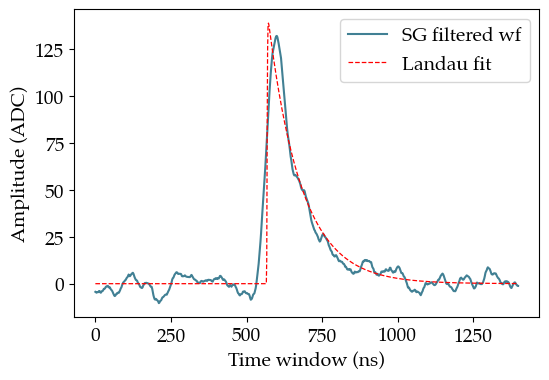

In [160]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)

rng      = (100, 200)
plt.figure(figsize=(6, 4))
sel_swfs = (max_swfs > rng[0]) & (max_swfs < rng[1])
swfs0    = swfs[sel_swfs]
wf       = savgol_filter(swfs0[1], window_length=50, polyorder=3)

x = 2*np.arange(len(wf[np.argmax(wf)-300:np.argmax(wf)+400]))
y = wf[np.argmax(wf)-300:np.argmax(wf)+400]
plt.plot(x, y, color=col, label='SG filtered wf')

p0 = [x[np.argmax(y)], 1.0, max(y)]  # Initial guess: [peak position, width, amplitude]
popt, pcov = curve_fit(landau, x, y, p0=p0)
mpv, eta, scale = popt

x_fit = np.linspace(min(x), max(x), 1000)
y_fit = landau(x_fit, *popt)

plt.plot(x_fit, y_fit, 'r--', lw=0.9, label='Landau fit')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/wf_SG_Landau_fit.pdf', bbox_inches='tight')
plt.show()

## Average single PE waveforms

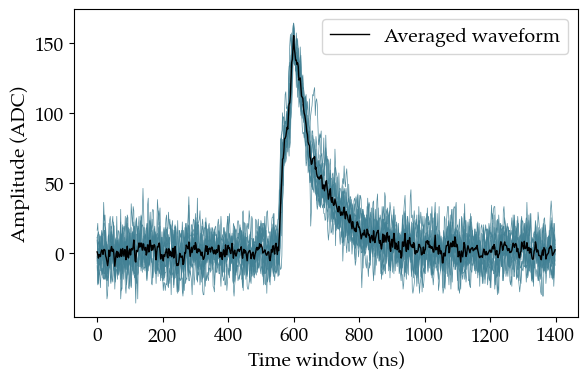

In [186]:
ch   = 8
wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=True, wf_range_bsl=(0, 500))
max_swfs = np.max(swfs, axis=1)
single_pe_rng = (100, 200)

plt.figure(figsize=(6.5, 4))

sel_swfs = (max_swfs > single_pe_rng[0]) & (max_swfs < single_pe_rng[1])
swfs0    = swfs[sel_swfs]
all_wfs_rng = []
for i, wf in enumerate(swfs0[:15]):
    wf_x = 2*np.arange(len(wf[np.argmax(wf)-300:np.argmax(wf)+400]))
    wf_y = wf[np.argmax(wf)-300:np.argmax(wf)+400]
    if len(wf_y)!=700:
        continue
    all_wfs_rng.append(wf_y)
    plt.plot(wf_x, wf_y, lw=0.5, color=fav_col, alpha=0.9)

average_waveform = np.mean(np.array(all_wfs_rng), axis=0)
plt.plot(wf_x, average_waveform, label='Averaged waveform', color='k', linewidth=1)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/averaged_single_PE_wfs.pdf', bbox_inches='tight')
plt.show()

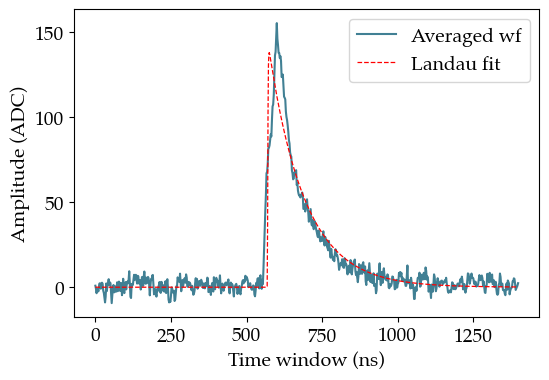

In [187]:
plt.figure(figsize=(6, 4))
x = wf_x
y = average_waveform
plt.plot(x, y, color=col, label='Averaged wf')

p0 = [x[np.argmax(y)], 1.0, max(y)]  # Initial guess: [peak position, width, amplitude]
popt, pcov = curve_fit(landau, x, y, p0=p0)
mpv, eta, scale = popt

x_fit = np.linspace(min(x), max(x), 1000)
y_fit = landau(x_fit, *popt)

plt.plot(x_fit, y_fit, 'r--', lw=0.9, label='Landau fit')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/averaged_single_PE_wfs_fit_Landau.pdf', bbox_inches='tight')
plt.show()

## Compute time of the peak with inversion, shifting and summing

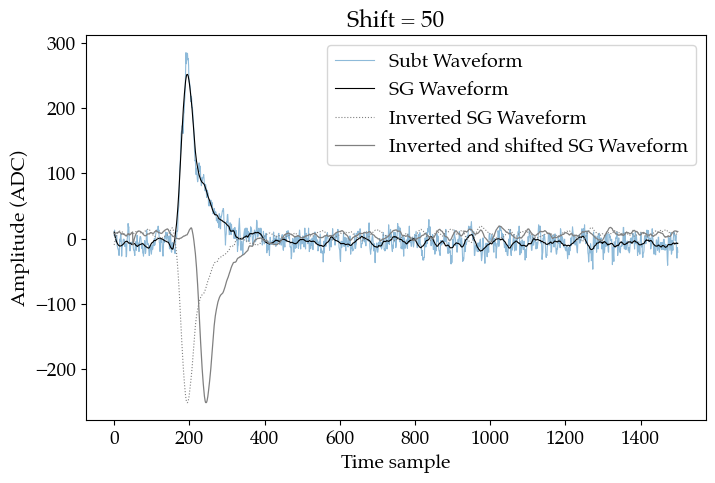

In [362]:
ch  = 8
wfs = np.array(RawTree[f'chan{ch}/rdigi'].array())
wf  = wfs[38]
swf = pf.subtract_baseline(wf, mode=True, wf_range_bsl=(0, 650))
fwf = savgol_filter(swf, window_length=50, polyorder=3)

diff_peaks   = 100000
chosen_shift = 50
n_time_samp  = 1500

plt.figure(figsize=(8, 5))
plt.plot( swf[:n_time_samp],           lw=0.8, alpha=0.5, label="Subt Waveform")
plt.plot( fwf[:n_time_samp], c='k',    lw=0.8,            label="SG Waveform")
plt.plot(-fwf[:n_time_samp], c='grey', lw=0.8, ls=':',    label="Inverted SG Waveform")
plt.plot(np.concatenate((-fwf[n_time_samp:n_time_samp+chosen_shift], -fwf[:n_time_samp-chosen_shift])), c='grey', lw=0.9, label="Inverted and shifted SG Waveform")
#plt.plot(np.concatenate((-fwf[n_time_samp:n_time_samp+chosen_shift], -fwf[:n_time_samp-chosen_shift]))+fwf[:n_time_samp], c='r', ls='--', lw=0.9, label="Sum SG wf and Inverted and shifted SG wf")
plt.xlabel('Time sample', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.title(f'Shift = {chosen_shift}')
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/invert_and_shift_wf.pdf', bbox_inches='tight')
plt.show()

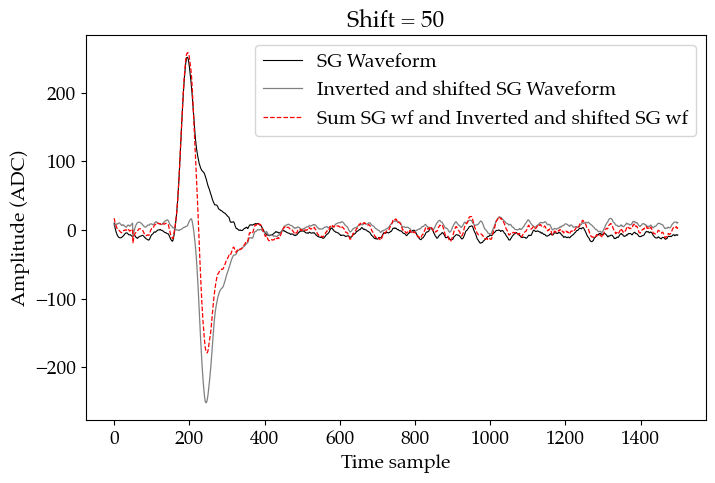

In [360]:
wf  = wfs[38]
swf = pf.subtract_baseline(wf, mode=True, wf_range_bsl=(0, 650))
fwf = savgol_filter(swf, window_length=50, polyorder=3)

diff_peaks   = 100000
chosen_shift = 50
n_time_samp  = 1500

#for shift in np.arange(150, 160):
#
#    min_diff = np.max(fwf[shift:2000+shift]-fwf[:2000]) + np.min(fwf[shift:2000+shift]-fwf[:2000])
#    if min_diff < diff_peaks:
#        diff_peaks   = min_diff
#        chosen_shift = shift
    

plt.figure(figsize=(8, 5))
plt.plot( fwf[:n_time_samp], c='k',    lw=0.8,            label="SG Waveform")
plt.plot(np.concatenate((-fwf[n_time_samp:n_time_samp+chosen_shift], -fwf[:n_time_samp-chosen_shift])), c='grey', lw=0.9, label="Inverted and shifted SG Waveform")
plt.plot(np.concatenate((-fwf[n_time_samp:n_time_samp+chosen_shift], -fwf[:n_time_samp-chosen_shift]))+fwf[:n_time_samp], c='r', ls='--', lw=0.9, label="Sum SG wf and Inverted and shifted SG wf")
plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.title(f'Shift = {chosen_shift}')
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/invert_wf_sum.pdf', bbox_inches='tight')
plt.show()

## Compare different methods to compute baselines

In [213]:
ch       = 8
wfs      = np.array(RawTree[f'chan{ch}/rdigi'].array())
bsl_mode = np.array([pf.compute_baseline(wf, mode=True,  wf_range_bsl=(0, 650)) for wf in wfs])
bsl_mean = np.array([pf.compute_baseline(wf, mode=False, wf_range_bsl=(0, 650)) for wf in wfs])

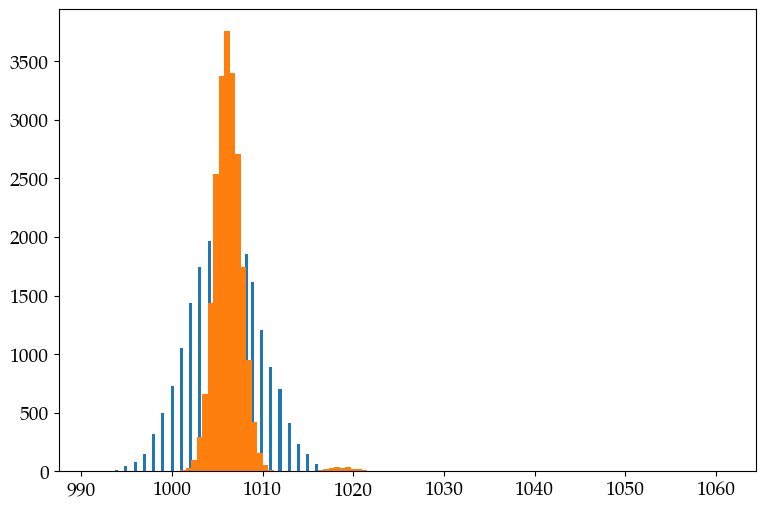

In [201]:
plt.hist(bsl_mode, bins=100)
plt.hist(bsl_mean, bins=100);

In [204]:
np.where(bsl_mean>1020)

(array([   38,   756,  1194,  1483,  1866,  2190,  2319,  2634,  2681,
         3052,  3340,  3736,  3738,  3756,  3810,  4023,  4275,  4390,
         4392,  4485,  4674,  4859,  5036,  5316,  5733,  5961,  6112,
         6409,  7787,  7917,  7973,  8089,  8334,  9280,  9671,  9978,
        10377, 10396, 10946, 10964, 11042, 11200, 11326, 11580, 11617,
        11791, 11949, 12160, 12235, 12762, 12969, 13432, 13445, 13851,
        13915, 13969, 13974, 14060, 14068, 14142, 14955, 15092, 15610,
        15767, 15982, 16084, 16183, 16247, 16320, 16373, 16454, 16585,
        16771, 16880, 17110, 17254, 17507, 17525, 17526, 18035, 18355,
        18663, 18751, 18861, 19115, 19145, 19647, 19995, 20026, 20413,
        20422, 20579, 20799, 21172, 21271, 21397, 21700, 21939]),)

1013.5930232558139
1010.975
1007.6046511627907
1034.2507692307693 1016.0
21.08478813679031 56.280507960850535


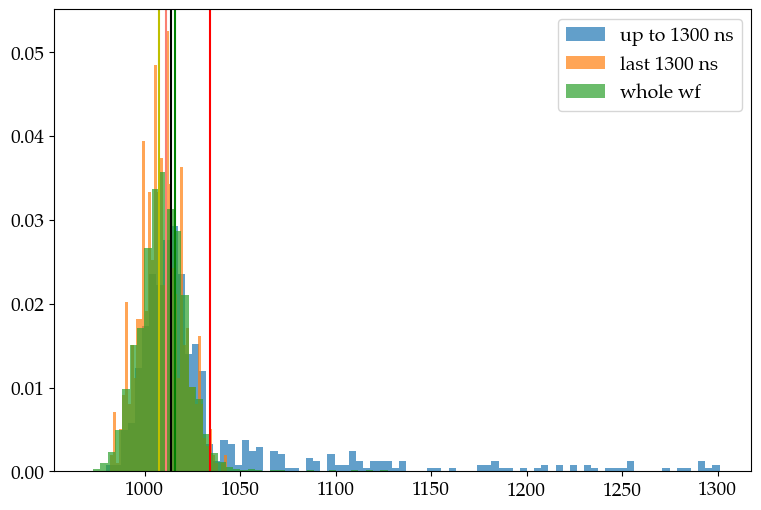

In [271]:
from scipy import stats as st

for wf in wfs[38:39]:
    y, x, _ = plt.hist(wf[:650], bins=86, density=True, alpha=0.7, label='up to 1300 ns')
    print(x[np.argmax(y)])
    plt.axvline(x[np.argmax(y)], color='k')
    
    y, x, _ = plt.hist(wf[-650:], bins=40, density=True, alpha=0.7, label='last 1300 ns')
    print(x[np.argmax(y)])
    plt.axvline(x[np.argmax(y)], color='salmon')
    
    y, x, _ = plt.hist(wf,       bins=86, density=True, alpha=0.7, label='whole wf')
    print(x[np.argmax(y)])
    plt.axvline(x[np.argmax(y)], color='y')
    
    plt.axvline(np.mean(wf[:650]), color='r')
    plt.axvline(st.mode(wf[:650], keepdims=False).mode.astype(np.float32), color='g')
    
    
    print(np.mean(wf[:650]), st.mode(wf[:650], keepdims=False).mode.astype(np.float32))
    print(np.std(wf), np.std(wf[:650]))
    plt.legend()
    plt.show()

1004.5
1014.0
1007.046511627907
1007.9723076923077 1005.0
11.264532641289058 10.893434969915916


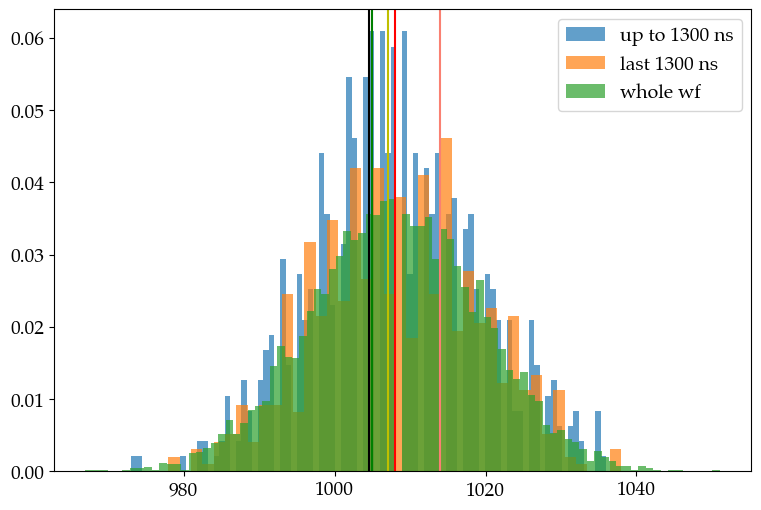

In [266]:
from scipy import stats as st

for wf in wfs[37:38]:
    y, x, _ = plt.hist(wf[:650], bins=86, density=True, alpha=0.7, label='up to 1300 ns')
    print(x[np.argmax(y)])
    plt.axvline(x[np.argmax(y)], color='k')
    
    y, x, _ = plt.hist(wf[-650:], bins=40, density=True, alpha=0.7, label='last 1300 ns')
    print(x[np.argmax(y)])
    plt.axvline(x[np.argmax(y)], color='salmon')
    
    y, x, _ = plt.hist(wf,       bins=86, density=True, alpha=0.7, label='whole wf')
    print(x[np.argmax(y)])
    plt.axvline(x[np.argmax(y)], color='y')
    
    plt.axvline(np.mean(wf[:650]), color='r')
    plt.axvline(st.mode(wf[:650], keepdims=False).mode.astype(np.float32), color='g')
    
    
    print(np.mean(wf[:650]), st.mode(wf[:650], keepdims=False).mode.astype(np.float32))
    print(np.std(wf), np.std(wf[:650]))
    plt.legend()
    plt.show()

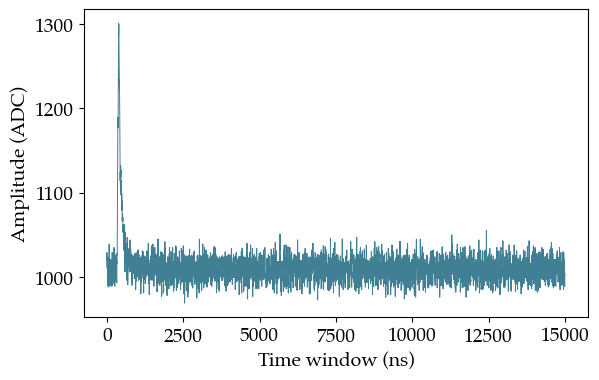

In [252]:
wf = wfs[38]

plt.figure(figsize=(6.5, 4))
plt.plot(2*np.arange(len(wf)), wf, color=fav_col, linewidth=0.7)
plt.xlabel('Time window (ns)', fontsize=14)

plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.show()

#### Try to fit the gaussian and take mu and sigma

In [227]:
wf0 = wf[:650]

counts, bin_edges = np.histogram(wf0, bins=85)
mean_v = bin_edges[np.argmax(counts)]

fvals = fitf.gaussian_fit_IC(wf0, bins=85, ampl=3000, prange=(np.min(wf0), np.max(wf0)),
                 mean=mean_v, sigma=20, frange=(mean_v-20, mean_v+20), title=f'', units='ADC',
                 xlabel='Amplitude (ADC)', print_chi2=False, ndec=3)

f = fit(gauss, shift_to_bin_centers(bin_edges), counts, (3000,mean_v,20), fit_range=(mean_v-20, mean_v+20), sigma=np.sqrt(counts))

_, mu, sigma = f.values

wf_filt = wf0[np.where(wf0>(mu-3*sigma))[0][0]&np.where(wf0<(mu+3*sigma))[0][0]]

NameError: name 'namedtuple' is not defined

In [240]:
def fit_baseline(wf):
    print(1)
    counts, bin_edges = np.histogram(wf, bins=85)
    bin_centers = fitf.shift_to_bin_centers(bin_edges)

    mean_v    = bin_centers[np.argmax(counts)]
    init_vals = (np.max(counts), mean_v, 20)  # amplitude, mean, sigma

    errs = np.sqrt(counts)
    errs = np.where(errs <= 0, 1e-6, errs)

    f = fitf.fit(fitf.gauss, bin_centers, counts, seed=init_vals, fit_range=(mean_v-20, mean_v+20), sigma=errs)
    _, mu, sigma = f.values

    wf_filt = wf[(wf > mu - 3 * sigma) & (wf < mu + 3 * sigma)]

    mean_baseline = np.mean(wf_filt)
    return mean_baseline

from joblib import Parallel, delayed

baseline_values = Parallel(n_jobs=-1)(delayed(fit_baseline)(wf) for wf in wfs)

#for i, wf in enumerate(wfs):
#    print(i, fit_baseline(wf))


/Users/romoluque_c/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/romoluque_c/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/romoluque_c/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/Users/romoluque_c/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/romoluque_c/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/romoluque_c/anaconda3/lib/python3.10/site-packages/numpy/

TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=1

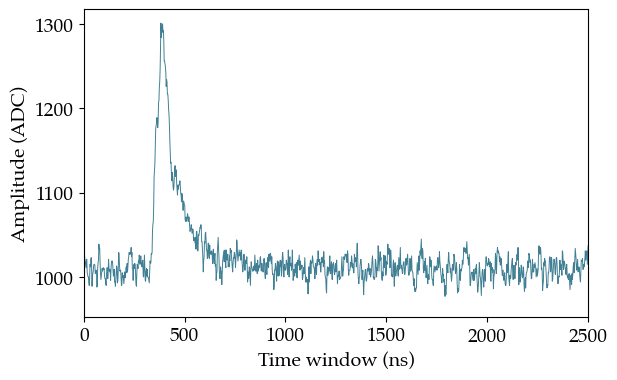

In [228]:
wf = wfs[38]

plt.figure(figsize=(6.5, 4))
plt.plot(2*np.arange(len(wf)), wf, color=fav_col, linewidth=0.7)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(0, 2500)
plt.show()

In [241]:
import numpy as np

def compute_baseline(wf, num_std_devs=3):
    """
    Compute the baseline of a waveform by excluding points that are more than
    `num_std_devs` standard deviations from the mean.

    Parameters:
    - wf: The waveform (1D numpy array).
    - num_std_devs: The number of standard deviations used to define the "good" part
      of the waveform. Default is 3.

    Returns:
    - mean_baseline: The computed baseline (mean of "good" part of the waveform).
    """
    # Calculate the mean and standard deviation of the waveform
    mean_wf = np.mean(wf)
    std_wf = np.std(wf)

    # Define the bounds to filter out the "bad" data (e.g., light peaks)
    lower_bound = mean_wf - num_std_devs * std_wf
    upper_bound = mean_wf + num_std_devs * std_wf

    # Filter the waveform by excluding values outside of the specified range
    good_values = wf[(wf >= lower_bound) & (wf <= upper_bound)]

    # Compute the mean of the "good" part of the waveform (the baseline)
    mean_baseline = np.mean(good_values)
    return mean_baseline

# Example usage with random waveform data
wf_example = np.random.normal(0, 1, 1000)  # Simulated noise waveform
wf_example[500:550] = np.random.normal(10, 1, 50)  # Add a "peak" for light detection

baseline = compute_baseline(wf_example)
print("Baseline:", baseline)


Baseline: 0.010480227506923852


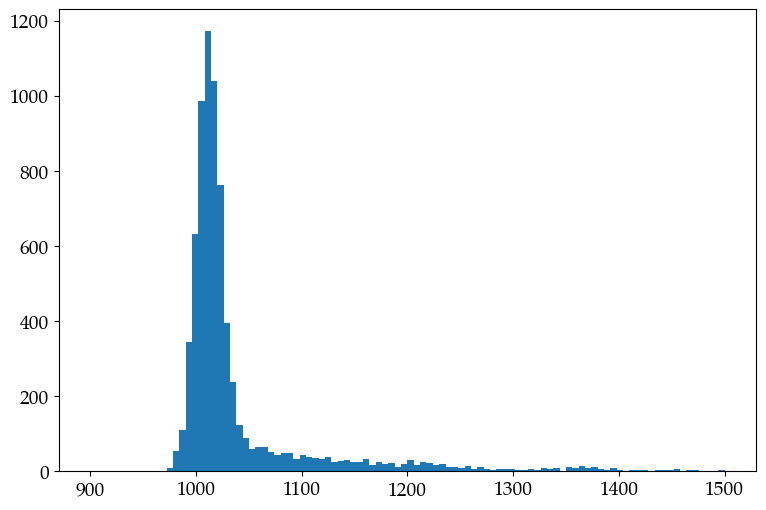

In [243]:
plt.hist(wf, bins=100, range=(900, 1500));

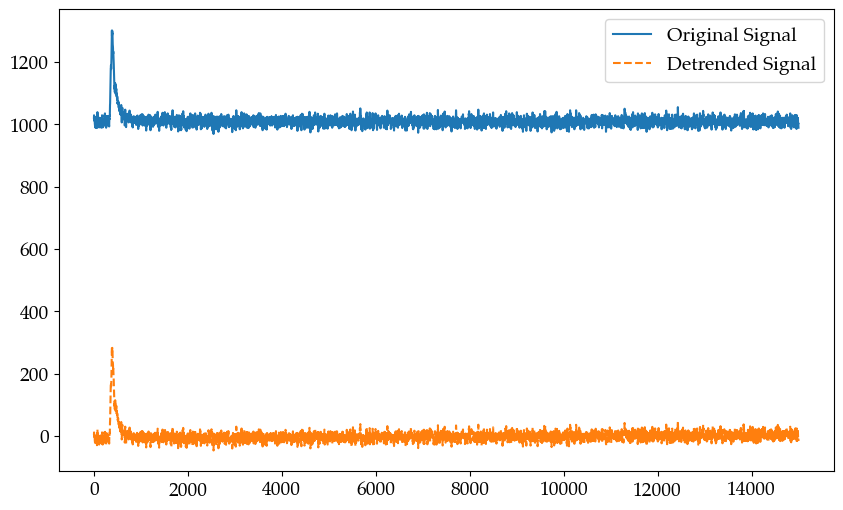

In [255]:
from scipy.signal import detrend

detrended_signal = detrend(wf, type='linear')

plt.figure(figsize=(10, 6))
plt.plot(2*np.arange(len(wf)), wf, label='Original Signal')
plt.plot(2*np.arange(len(wf)), detrended_signal, label='Detrended Signal', linestyle='dashed')
plt.legend()
plt.show()


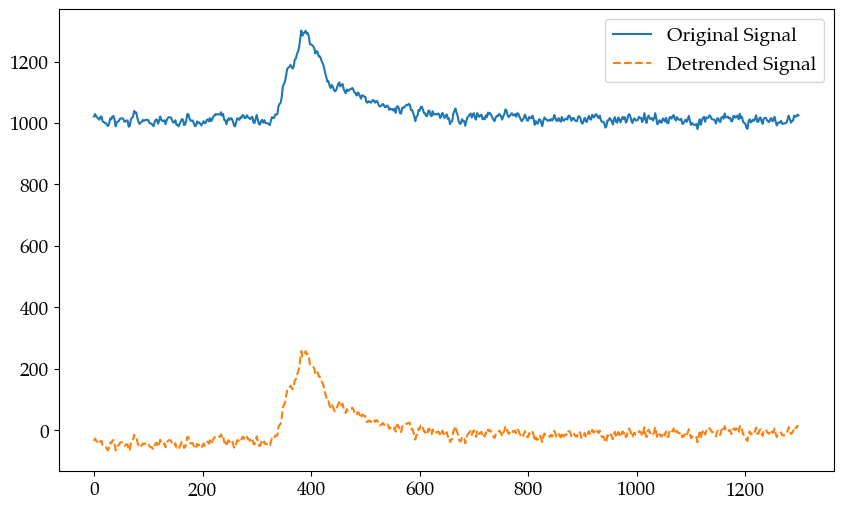

In [260]:
detrended_signal = detrend(wf[:650], type='linear')

plt.figure(figsize=(10, 6))
plt.plot(2*np.arange(len(wf[:650])), wf[:650], label='Original Signal')
plt.plot(2*np.arange(len(wf[:650])), detrended_signal, label='Detrended Signal', linestyle='dashed')
plt.legend()
plt.show()


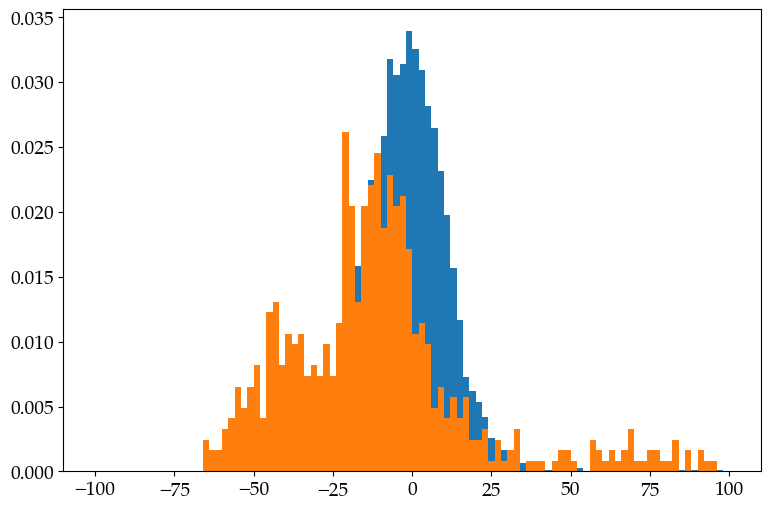

In [259]:
plt.hist(detrend(wf,       type='linear'), bins=100, range=(-100, 100), density=True);
plt.hist(detrend(wf[:650], type='linear'), bins=100, range=(-100, 100), density=True);

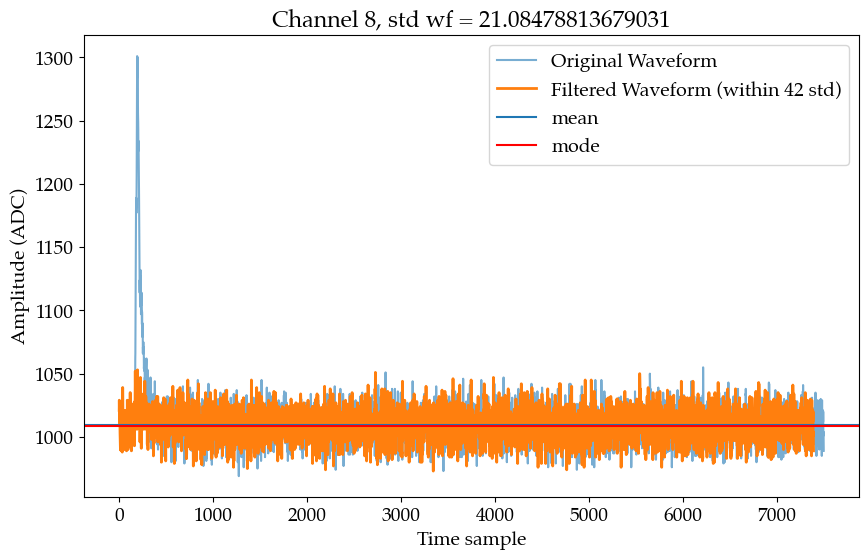

In [391]:
std_chs = 14 #more or less for all channels between 12 and 14
std_lim = std_chs*3
for ch in range(9):
    if ch!=8:
        continue
    wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[38]

    lower_bound = np.mean(wf) - std_lim #ADC
    upper_bound = np.mean(wf) + std_lim #ADC
    filtered_waveform = wf[(wf >= lower_bound) & (wf <= upper_bound)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(wf, label="Original Waveform", alpha=0.6)
    plt.plot(filtered_waveform, label=f"Filtered Waveform (within {std_lim} std)", linewidth=2)
    plt.axhline(np.mean(filtered_waveform), label='mean')
    plt.axhline(st.mode(filtered_waveform, keepdims=False).mode.astype(np.float32), c='r', label='mode')
    plt.title(f'Channel {ch}, std wf = {np.std(wf)}')
    plt.xlabel('Time sample',     fontsize=14)
    plt.ylabel('Amplitude (ADC)', fontsize=14)
    plt.legend()
    plt.show()

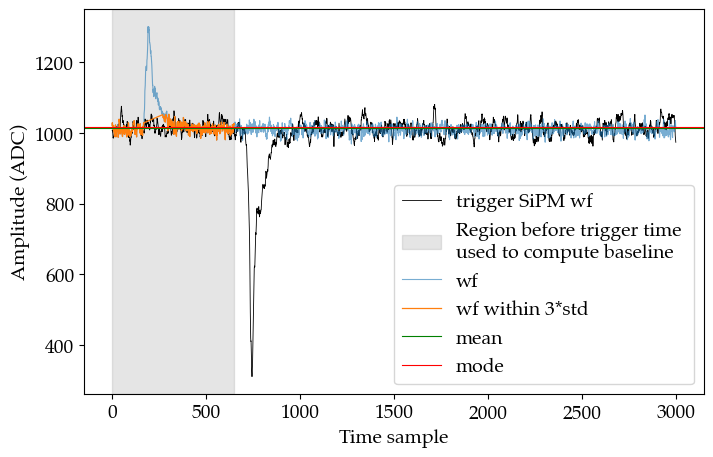

In [409]:
wf_ch8 = np.array(RawTree[f'chan8/rdigi'].array())[38]
wf_ch9 = np.array(RawTree[f'chan9/rdigi'].array())[38]

std_chs = 14 #more or less for all channels between 12 and 14
std_lim = std_chs*3

low_bnd = np.mean(wf_ch8) - std_lim #ADC
upp_bnd = np.mean(wf_ch8) + std_lim #ADC
#filt_wf_ch8 = wf_ch8[(wf_ch8 >= low_bnd) & (wf_ch8 <= upp_bnd)]
filt_wf_ch8 = wf_ch8[:650]  [(wf_ch8[:650] >= low_bnd) & (wf_ch8[:650] <= upp_bnd)]
xvals       = np.arange(650)[(wf_ch8[:650] >= low_bnd) & (wf_ch8[:650] <= upp_bnd)]


plt.figure(figsize=(8, 5))
plt.plot(wf_ch9     [:3000]+(np.mean(filt_wf_ch8) - np.mean(wf_ch9[3000:])), label="trigger SiPM wf", lw=0.6, c='k')
plt.axvspan(0, 650, color='grey', alpha=0.2, label='Region before trigger time \nused to compute baseline')
plt.plot(wf_ch8     [:3000], label="wf", alpha=0.6, lw=0.8)
#plt.plot(filt_wf_ch8[:650],  label=f"wf within 3*std", lw=0.9)
plt.plot(xvals, filt_wf_ch8[:650],  label=f"wf within 3*std", lw=0.9)
plt.axhline(np.mean(filt_wf_ch8[:650]), label='mean', lw=0.8, c='g')
plt.axhline(st.mode(filt_wf_ch8[:650], keepdims=False).mode.astype(np.float32), c='r', label='mode', lw=0.8)
plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.legend()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/baseline_computation_final.pdf', bbox_inches='tight')
plt.show()

### Case of a trigger SiPM

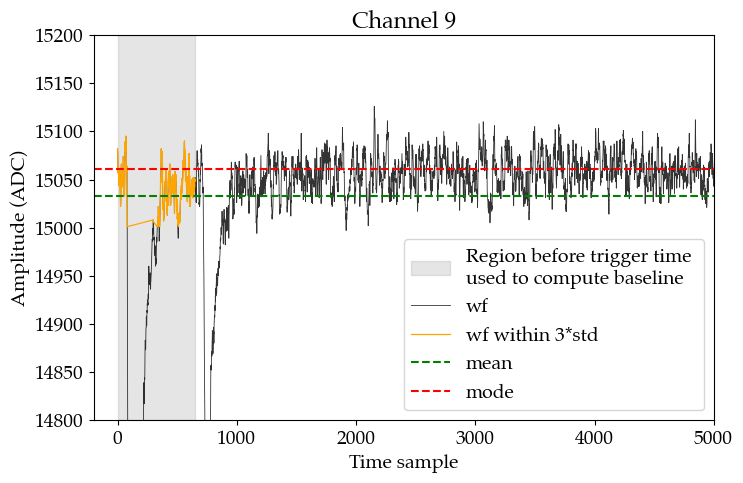

In [463]:
wf_ch9 = np.array(RawTree[f'chan9/rdigi'].array())[132]

std_chs = 20
std_lim = std_chs*3

low_bnd = st.mode(wf_ch9, keepdims=False).mode.astype(np.float32) - std_lim #ADC
upp_bnd = st.mode(wf_ch9, keepdims=False).mode.astype(np.float32) + std_lim #ADC
filt_wf_ch9 = wf_ch9[:650]  [(wf_ch9[:650] >= low_bnd) & (wf_ch9[:650] <= upp_bnd)]
xvals       = np.arange(650)[(wf_ch9[:650] >= low_bnd) & (wf_ch9[:650] <= upp_bnd)]


plt.figure(figsize=(8, 5))
plt.axvspan(0, 650, color='grey', alpha=0.2, label='Region before trigger time \nused to compute baseline')
plt.plot(wf_ch9, lw=0.6, c='k', label='wf', alpha=0.8)
plt.plot(xvals, filt_wf_ch9,  label=f"wf within 3*std", lw=0.9, color='orange')
#plt.axhline(np.mean(wf_ch9[:650]), c='g', label='mean')
#plt.axhline(st.mode(wf_ch9[:650], keepdims=False).mode.astype(np.float32), c='r', label='mode')
plt.axhline(np.mean(wf_ch9), c='g', label='mean', ls='--')
plt.axhline(st.mode(wf_ch9, keepdims=False).mode.astype(np.float32), c='r', label='mode', ls='--')

plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.title('Channel 9')
plt.legend()
plt.xlim(-200, 5000)
plt.ylim(14800, 15200)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/baseline_computation_final_ch9.pdf', bbox_inches='tight')
plt.show()

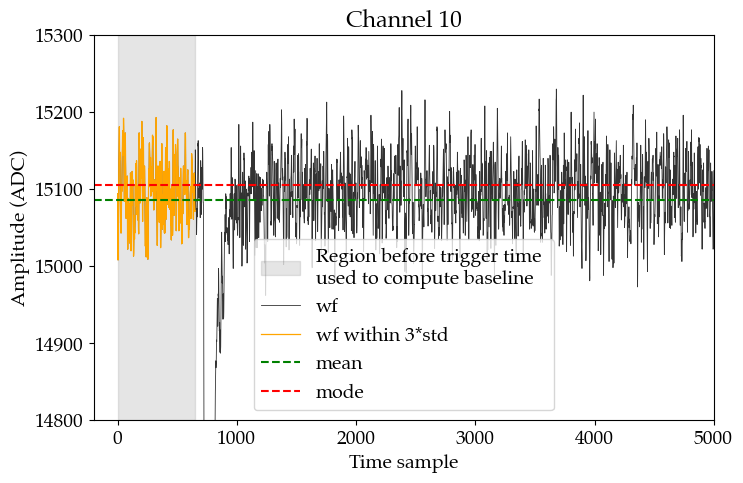

In [474]:
wf_ch10 = np.array(RawTree[f'chan10/rdigi'].array())[132]

std_chs = 40
std_lim = std_chs*3

low_bnd = st.mode(wf_ch10, keepdims=False).mode.astype(np.float32) - std_lim #ADC
upp_bnd = st.mode(wf_ch10, keepdims=False).mode.astype(np.float32) + std_lim #ADC
filt_wf_ch10 = wf_ch10[:650]  [(wf_ch10[:650] >= low_bnd) & (wf_ch10[:650] <= upp_bnd)]
xvals       = np.arange(650)[(wf_ch10[:650] >= low_bnd) & (wf_ch10[:650] <= upp_bnd)]


plt.figure(figsize=(8, 5))
plt.axvspan(0, 650, color='grey', alpha=0.2, label='Region before trigger time \nused to compute baseline')
plt.plot(wf_ch10, lw=0.6, c='k', label='wf', alpha=0.8)
plt.plot(xvals, filt_wf_ch10,  label=f"wf within 3*std", lw=0.9, color='orange')
plt.axhline(np.mean(wf_ch10), c='g', label='mean', ls='--')
plt.axhline(st.mode(wf_ch10, keepdims=False).mode.astype(np.float32), c='r', label='mode', ls='--')

plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.title('Channel 10')
plt.legend()
plt.xlim(-200, 5000)
plt.ylim(14800, 15300)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/baseline_computation_final_ch10.pdf', bbox_inches='tight')
plt.show()

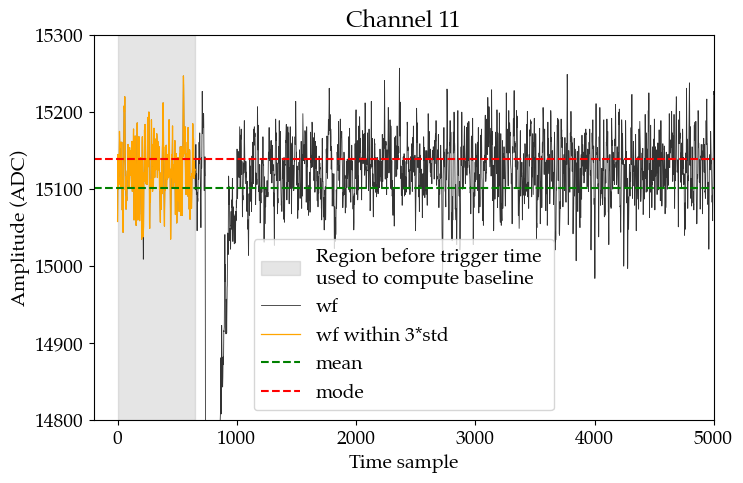

In [473]:
wf_ch11 = np.array(RawTree[f'chan11/rdigi'].array())[131]

std_chs = 40
std_lim = std_chs*3

low_bnd = st.mode(wf_ch11, keepdims=False).mode.astype(np.float32) - std_lim #ADC
upp_bnd = st.mode(wf_ch11, keepdims=False).mode.astype(np.float32) + std_lim #ADC
filt_wf_ch11 = wf_ch11[:650]  [(wf_ch11[:650] >= low_bnd) & (wf_ch11[:650] <= upp_bnd)]
xvals       = np.arange(650)[(wf_ch11[:650] >= low_bnd) & (wf_ch11[:650] <= upp_bnd)]


plt.figure(figsize=(8, 5))
plt.axvspan(0, 650, color='grey', alpha=0.2, label='Region before trigger time \nused to compute baseline')
plt.plot(wf_ch10, lw=0.6, c='k', label='wf', alpha=0.8)
plt.plot(xvals, filt_wf_ch11,  label=f"wf within 3*std", lw=0.9, color='orange')
plt.axhline(np.mean(wf_ch11), c='g', label='mean', ls='--')
plt.axhline(st.mode(wf_ch11, keepdims=False).mode.astype(np.float32), c='r', label='mode', ls='--')

plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.title('Channel 11')
plt.legend()
plt.xlim(-200, 5000)
plt.ylim(14800, 15300)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/baseline_computation_final_ch11.pdf', bbox_inches='tight')
plt.show()

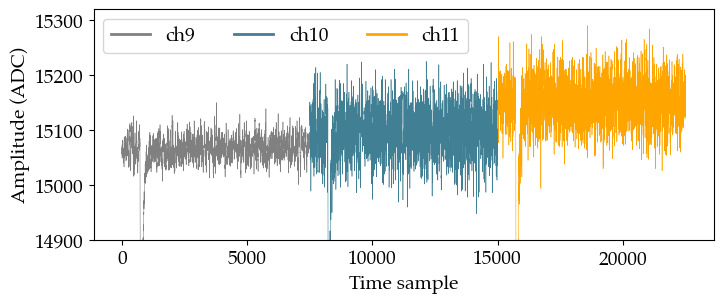

In [489]:
wf_ch9  = np.array(RawTree[f'chan9/rdigi'] .array())[1]
wf_ch10 = np.array(RawTree[f'chan10/rdigi'].array())[1]
wf_ch11 = np.array(RawTree[f'chan11/rdigi'].array())[1]

plt.figure(figsize=(8, 3))
plt.plot(                     wf_ch9,  lw=0.4, c='grey',   label='ch9')
plt.plot(range(7500, 15000),  wf_ch10, lw=0.4, c=fav_col,  label='ch10')
plt.plot(range(15000, 22500), wf_ch11, lw=0.4, c='orange', label='ch11')
plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.ylim(14900, 15320)
leg = plt.legend(ncol=3)
for line in leg.get_lines():
    line.set_linewidth(2)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/baseline_example_trigg_chs.pdf', bbox_inches='tight')
plt.show()

## Baseline comparison at the beginning and end of waveform

In [492]:
wfs_ch8 = np.array(RawTree[f'chan8/rdigi'].array())
bsl_mean_i = np.array([pf.compute_baseline(wf, mode=False, wf_range_bsl=(       0,  650)) for wf in wfs_ch8])
bsl_mean_f = np.array([pf.compute_baseline(wf, mode=False, wf_range_bsl=(7500-650, 7500)) for wf in wfs_ch8])
bsl_mode_i = np.array([pf.compute_baseline(wf, mode=True,  wf_range_bsl=(       0,  650)) for wf in wfs_ch8])
bsl_mode_f = np.array([pf.compute_baseline(wf, mode=True,  wf_range_bsl=(7500-650, 7500)) for wf in wfs_ch8])

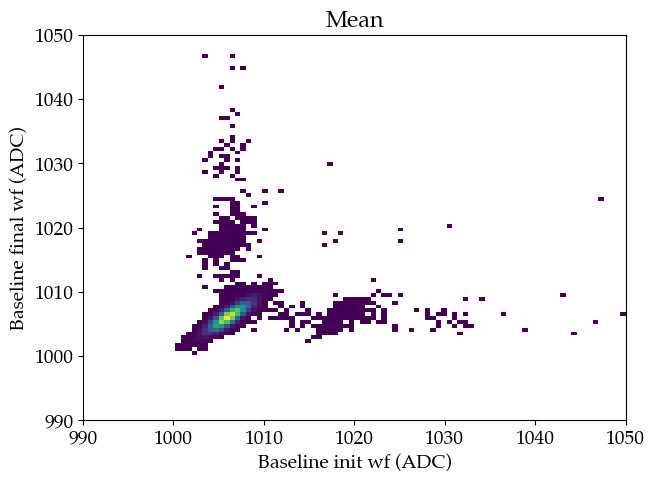

In [508]:
plt.figure(figsize=(7, 5))
plt.hist2d(bsl_mean_i, bsl_mean_f, bins=(100, 100), cmin=1, range=((990, 1050), (990, 1050)))
plt.xlabel('Baseline init wf (ADC)')
plt.ylabel('Baseline final wf (ADC)')
plt.title('Mean')
plt.show()

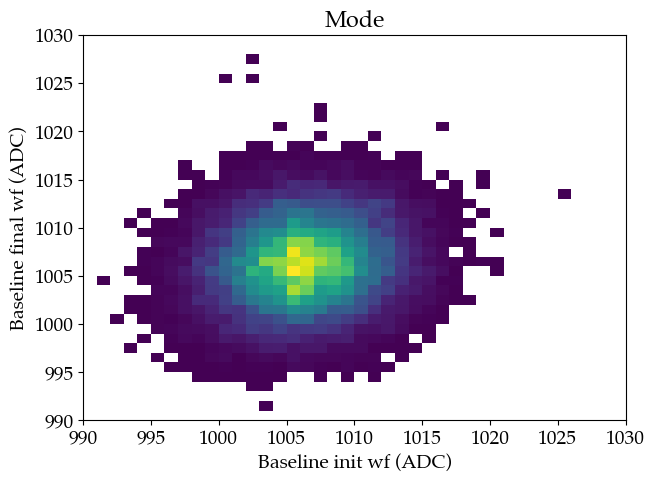

In [515]:
plt.figure(figsize=(7, 5))
plt.hist2d(bsl_mode_i, bsl_mode_f, bins=(40, 40), cmin=1, range=((990, 1030), (990, 1030)))
plt.xlabel('Baseline init wf (ADC)')
plt.ylabel('Baseline final wf (ADC)')
plt.title('Mode')
plt.show()

In [502]:
np.where(bsl_mean_f>1350)
#, bsl_mean_f)

(array([15610]),)

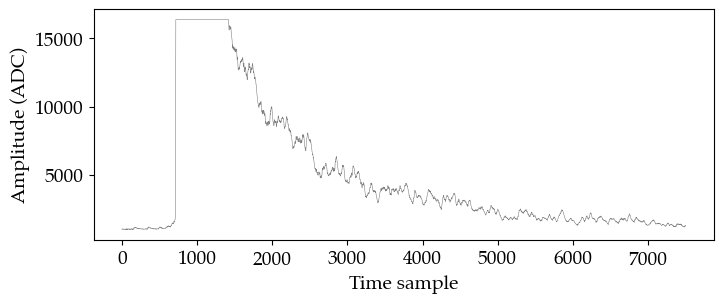

In [503]:
wf_ch8 = np.array(RawTree[f'chan8/rdigi'].array())[15610]
plt.figure(figsize=(8, 3))
plt.plot(wf_ch8, lw=0.4, c='grey', label='ch8')
plt.xlabel('Time sample',     fontsize=14)
plt.ylabel('Amplitude (ADC)', fontsize=14)
plt.show()